In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, concatenate
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
dataset = pd.read_csv('../../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [7]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [8]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [9]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [10]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [11]:
# prior_known_supervised

### N_out, N_in, K

In [12]:
past_cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (96337, 1440)


In [13]:
# past_cov_supervised  # 6 + 9 = 15 features

In [14]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [15]:
# past_ws_supervised  # 4

In [16]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [17]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [18]:
# past_cov_ws_supervised

In [19]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


In [20]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
                                                     axis=1)


In [21]:
# shift_prior_known_past_cov_ws_supervised

In [22]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [23]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


### Train & Test set

In [24]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [25]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [26]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


### Model

In [30]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))
x = layers.SimpleRNN(128, 
                     activation='relu', 
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     return_sequences=True)(model_input)

x_merge1 = concatenate([model_input, x])
x = layers.SimpleRNN(64, 
                     activation='relu', 
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     return_sequences=True)(x_merge1)

x_merge2 = concatenate([model_input, x])
x = layers.SimpleRNN(32, 
                     activation='relu', 
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     return_sequences=True)(x_merge2)

x_merge3 = concatenate([model_input, x])
x = layers.SimpleRNN(16, 
                     activation='relu', 
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     return_sequences=True)(x_merge3)

merge = concatenate([model_input, x])

x = layers.Flatten()(x)
# x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
# x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-4, l2=1e-4))(x)
# x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4))(x)

output = layers.Dense(train_y.shape[1])(x)

model_rnn = Model(model_input, output)
model_rnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 28)]     0                                            
__________________________________________________________________________________________________
simple_rnn_3 (SimpleRNN)        (None, 72, 128)      20096       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 72, 156)      0           input_2[0][0]                    
                                                                 simple_rnn_3[0][0]               
__________________________________________________________________________________________________
simple_rnn_4 (SimpleRNN)        (None, 72, 64)       14144       concatenate_3[0][0]        

Epoch 1/8000


2023-01-07 17:14:22.639830: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10



Epoch 00001: val_mae improved from inf to 0.08643, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 18s - loss: 0.0634 - mae: 0.1128 - val_loss: 0.0479 - val_mae: 0.0864
Epoch 2/8000

Epoch 00002: val_mae improved from 0.08643 to 0.06917, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 18s - loss: 0.0400 - mae: 0.0551 - val_loss: 0.0419 - val_mae: 0.0692
Epoch 3/8000

Epoch 00003: val_mae improved from 0.06917 to 0.06096, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 17s - loss: 0.0369 - mae: 0.0457 - val_loss: 0.0386 - val_mae: 0.0610
Epoch 4/8000

Epoch 00004: val_mae improved from 0.06096 to 0.05697, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 17s - loss: 0.0346 - mae: 0.0403 - val_loss: 0.0363 - val_mae: 0.0570
Epoch 5/8000

Epoch 00005: val_mae improved from 0.05697 to 0.05312, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 17s - loss: 0.0327 - mae: 0.0366

Epoch 41/8000

Epoch 00041: val_mae did not improve from 0.02939
151/151 - 16s - loss: 0.0035 - mae: 0.0162 - val_loss: 0.0042 - val_mae: 0.0294
Epoch 42/8000

Epoch 00042: val_mae did not improve from 0.02939
151/151 - 16s - loss: 0.0033 - mae: 0.0160 - val_loss: 0.0040 - val_mae: 0.0296
Epoch 43/8000

Epoch 00043: val_mae did not improve from 0.02939
151/151 - 16s - loss: 0.0030 - mae: 0.0158 - val_loss: 0.0038 - val_mae: 0.0294
Epoch 44/8000

Epoch 00044: val_mae improved from 0.02939 to 0.02886, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 16s - loss: 0.0028 - mae: 0.0157 - val_loss: 0.0035 - val_mae: 0.0289
Epoch 45/8000

Epoch 00045: val_mae did not improve from 0.02886
151/151 - 16s - loss: 0.0026 - mae: 0.0155 - val_loss: 0.0034 - val_mae: 0.0296
Epoch 46/8000

Epoch 00046: val_mae did not improve from 0.02886
151/151 - 16s - loss: 0.0024 - mae: 0.0154 - val_loss: 0.0032 - val_mae: 0.0292
Epoch 47/8000

Epoch 00047: val_mae improved from 0.02886 to 0.

Epoch 87/8000

Epoch 00087: val_mae improved from 0.02385 to 0.02359, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 16s - loss: 4.5379e-04 - mae: 0.0118 - val_loss: 0.0011 - val_mae: 0.0236
Epoch 88/8000

Epoch 00088: val_mae improved from 0.02359 to 0.02354, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 16s - loss: 4.4866e-04 - mae: 0.0117 - val_loss: 0.0010 - val_mae: 0.0235
Epoch 89/8000

Epoch 00089: val_mae improved from 0.02354 to 0.02352, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 16s - loss: 4.4406e-04 - mae: 0.0117 - val_loss: 0.0010 - val_mae: 0.0235
Epoch 90/8000

Epoch 00090: val_mae improved from 0.02352 to 0.02337, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 16s - loss: 4.3992e-04 - mae: 0.0116 - val_loss: 0.0010 - val_mae: 0.0234
Epoch 91/8000

Epoch 00091: val_mae improved from 0.02337 to 0.02323, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/

Epoch 133/8000

Epoch 00133: val_mae did not improve from 0.02065
151/151 - 16s - loss: 3.3826e-04 - mae: 0.0100 - val_loss: 8.6349e-04 - val_mae: 0.0209
Epoch 134/8000

Epoch 00134: val_mae did not improve from 0.02065
151/151 - 16s - loss: 3.3703e-04 - mae: 0.0100 - val_loss: 8.4811e-04 - val_mae: 0.0207
Epoch 135/8000

Epoch 00135: val_mae did not improve from 0.02065
151/151 - 16s - loss: 3.3572e-04 - mae: 0.0099 - val_loss: 8.7258e-04 - val_mae: 0.0210
Epoch 136/8000

Epoch 00136: val_mae improved from 0.02065 to 0.02056, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 16s - loss: 3.3417e-04 - mae: 0.0099 - val_loss: 8.3784e-04 - val_mae: 0.0206
Epoch 137/8000

Epoch 00137: val_mae did not improve from 0.02056
151/151 - 16s - loss: 3.3335e-04 - mae: 0.0099 - val_loss: 8.5005e-04 - val_mae: 0.0207
Epoch 138/8000

Epoch 00138: val_mae did not improve from 0.02056
151/151 - 16s - loss: 3.3183e-04 - mae: 0.0099 - val_loss: 8.4350e-04 - val_mae: 0.0206
Epoch 139

Epoch 182/8000

Epoch 00182: val_mae improved from 0.01901 to 0.01869, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 16s - loss: 2.9395e-04 - mae: 0.0091 - val_loss: 7.0863e-04 - val_mae: 0.0187
Epoch 183/8000

Epoch 00183: val_mae did not improve from 0.01869
151/151 - 16s - loss: 2.9327e-04 - mae: 0.0091 - val_loss: 7.1971e-04 - val_mae: 0.0188
Epoch 184/8000

Epoch 00184: val_mae did not improve from 0.01869
151/151 - 16s - loss: 2.9271e-04 - mae: 0.0091 - val_loss: 7.2602e-04 - val_mae: 0.0189
Epoch 185/8000

Epoch 00185: val_mae did not improve from 0.01869
151/151 - 16s - loss: 2.9226e-04 - mae: 0.0091 - val_loss: 7.3377e-04 - val_mae: 0.0190
Epoch 186/8000

Epoch 00186: val_mae did not improve from 0.01869
151/151 - 16s - loss: 2.9167e-04 - mae: 0.0091 - val_loss: 7.1320e-04 - val_mae: 0.0187
Epoch 187/8000

Epoch 00187: val_mae did not improve from 0.01869
151/151 - 16s - loss: 2.9097e-04 - mae: 0.0091 - val_loss: 7.4862e-04 - val_mae: 0.0192
Epoch 188

Epoch 232/8000

Epoch 00232: val_mae did not improve from 0.01772
151/151 - 16s - loss: 2.6844e-04 - mae: 0.0086 - val_loss: 6.5732e-04 - val_mae: 0.0180
Epoch 233/8000

Epoch 00233: val_mae did not improve from 0.01772
151/151 - 16s - loss: 2.6794e-04 - mae: 0.0086 - val_loss: 6.4071e-04 - val_mae: 0.0177
Epoch 234/8000

Epoch 00234: val_mae did not improve from 0.01772
151/151 - 16s - loss: 2.6778e-04 - mae: 0.0086 - val_loss: 6.7259e-04 - val_mae: 0.0182
Epoch 235/8000

Epoch 00235: val_mae did not improve from 0.01772
151/151 - 16s - loss: 2.6720e-04 - mae: 0.0086 - val_loss: 6.6045e-04 - val_mae: 0.0180
Epoch 236/8000

Epoch 00236: val_mae did not improve from 0.01772
151/151 - 16s - loss: 2.6676e-04 - mae: 0.0086 - val_loss: 6.5545e-04 - val_mae: 0.0179
Epoch 237/8000

Epoch 00237: val_mae did not improve from 0.01772
151/151 - 16s - loss: 2.6627e-04 - mae: 0.0086 - val_loss: 6.4702e-04 - val_mae: 0.0178
Epoch 238/8000

Epoch 00238: val_mae did not improve from 0.01772
151/151 - 

Epoch 283/8000

Epoch 00283: val_mae did not improve from 0.01687
151/151 - 16s - loss: 2.5137e-04 - mae: 0.0083 - val_loss: 6.1905e-04 - val_mae: 0.0174
Epoch 284/8000

Epoch 00284: val_mae did not improve from 0.01687
151/151 - 16s - loss: 2.5127e-04 - mae: 0.0083 - val_loss: 6.0167e-04 - val_mae: 0.0171
Epoch 285/8000

Epoch 00285: val_mae did not improve from 0.01687
151/151 - 17s - loss: 2.5108e-04 - mae: 0.0083 - val_loss: 5.9631e-04 - val_mae: 0.0170
Epoch 286/8000

Epoch 00286: val_mae did not improve from 0.01687
151/151 - 16s - loss: 2.5069e-04 - mae: 0.0083 - val_loss: 6.0358e-04 - val_mae: 0.0172
Epoch 287/8000

Epoch 00287: val_mae did not improve from 0.01687
151/151 - 16s - loss: 2.5035e-04 - mae: 0.0083 - val_loss: 5.9035e-04 - val_mae: 0.0170
Epoch 288/8000

Epoch 00288: val_mae did not improve from 0.01687
151/151 - 16s - loss: 2.5016e-04 - mae: 0.0083 - val_loss: 6.0650e-04 - val_mae: 0.0172
Epoch 289/8000

Epoch 00289: val_mae did not improve from 0.01687
151/151 - 

Epoch 334/8000

Epoch 00334: val_mae did not improve from 0.01647
151/151 - 16s - loss: 2.3967e-04 - mae: 0.0081 - val_loss: 5.7659e-04 - val_mae: 0.0167
Epoch 335/8000

Epoch 00335: val_mae did not improve from 0.01647
151/151 - 16s - loss: 2.3935e-04 - mae: 0.0081 - val_loss: 5.6166e-04 - val_mae: 0.0165
Epoch 336/8000

Epoch 00336: val_mae did not improve from 0.01647
151/151 - 16s - loss: 2.3924e-04 - mae: 0.0081 - val_loss: 5.9574e-04 - val_mae: 0.0171
Epoch 337/8000

Epoch 00337: val_mae did not improve from 0.01647
151/151 - 16s - loss: 2.3919e-04 - mae: 0.0081 - val_loss: 5.7516e-04 - val_mae: 0.0168
Epoch 338/8000

Epoch 00338: val_mae did not improve from 0.01647
151/151 - 16s - loss: 2.3879e-04 - mae: 0.0081 - val_loss: 5.6507e-04 - val_mae: 0.0165
Epoch 339/8000

Epoch 00339: val_mae did not improve from 0.01647
151/151 - 16s - loss: 2.3863e-04 - mae: 0.0081 - val_loss: 5.7983e-04 - val_mae: 0.0168
Epoch 340/8000

Epoch 00340: val_mae did not improve from 0.01647
151/151 - 


Epoch 00385: val_mae did not improve from 0.01595
151/151 - 16s - loss: 2.3050e-04 - mae: 0.0079 - val_loss: 5.6752e-04 - val_mae: 0.0166
Epoch 386/8000

Epoch 00386: val_mae did not improve from 0.01595
151/151 - 16s - loss: 2.3023e-04 - mae: 0.0079 - val_loss: 5.4026e-04 - val_mae: 0.0162
Epoch 387/8000

Epoch 00387: val_mae did not improve from 0.01595
151/151 - 16s - loss: 2.3012e-04 - mae: 0.0079 - val_loss: 5.4055e-04 - val_mae: 0.0162
Epoch 388/8000

Epoch 00388: val_mae did not improve from 0.01595
151/151 - 17s - loss: 2.2991e-04 - mae: 0.0079 - val_loss: 5.5454e-04 - val_mae: 0.0164
Epoch 389/8000

Epoch 00389: val_mae did not improve from 0.01595
151/151 - 16s - loss: 2.3008e-04 - mae: 0.0079 - val_loss: 5.3888e-04 - val_mae: 0.0161
Epoch 390/8000

Epoch 00390: val_mae did not improve from 0.01595
151/151 - 16s - loss: 2.2972e-04 - mae: 0.0079 - val_loss: 5.4303e-04 - val_mae: 0.0162
Epoch 391/8000

Epoch 00391: val_mae did not improve from 0.01595
151/151 - 16s - loss: 2.2

Epoch 437/8000

Epoch 00437: val_mae did not improve from 0.01565
151/151 - 16s - loss: 2.2308e-04 - mae: 0.0078 - val_loss: 5.2939e-04 - val_mae: 0.0160
Epoch 438/8000

Epoch 00438: val_mae did not improve from 0.01565
151/151 - 16s - loss: 2.2276e-04 - mae: 0.0078 - val_loss: 5.2678e-04 - val_mae: 0.0159
Epoch 439/8000

Epoch 00439: val_mae did not improve from 0.01565
151/151 - 16s - loss: 2.2277e-04 - mae: 0.0078 - val_loss: 5.1744e-04 - val_mae: 0.0158
Epoch 440/8000

Epoch 00440: val_mae did not improve from 0.01565
151/151 - 16s - loss: 2.2252e-04 - mae: 0.0078 - val_loss: 5.2012e-04 - val_mae: 0.0158
Epoch 441/8000

Epoch 00441: val_mae did not improve from 0.01565
151/151 - 16s - loss: 2.2244e-04 - mae: 0.0078 - val_loss: 5.1437e-04 - val_mae: 0.0158
Epoch 442/8000

Epoch 00442: val_mae did not improve from 0.01565
151/151 - 16s - loss: 2.2231e-04 - mae: 0.0078 - val_loss: 5.2505e-04 - val_mae: 0.0159
Epoch 443/8000

Epoch 00443: val_mae did not improve from 0.01565
151/151 - 

Epoch 489/8000

Epoch 00489: val_mae did not improve from 0.01539
151/151 - 16s - loss: 2.1688e-04 - mae: 0.0077 - val_loss: 5.1420e-04 - val_mae: 0.0158
Epoch 490/8000

Epoch 00490: val_mae did not improve from 0.01539
151/151 - 16s - loss: 2.1659e-04 - mae: 0.0076 - val_loss: 5.1609e-04 - val_mae: 0.0158
Epoch 491/8000

Epoch 00491: val_mae did not improve from 0.01539
151/151 - 16s - loss: 2.1653e-04 - mae: 0.0076 - val_loss: 4.9379e-04 - val_mae: 0.0154
Epoch 492/8000

Epoch 00492: val_mae did not improve from 0.01539
151/151 - 16s - loss: 2.1640e-04 - mae: 0.0076 - val_loss: 5.3273e-04 - val_mae: 0.0161
Epoch 493/8000

Epoch 00493: val_mae did not improve from 0.01539
151/151 - 16s - loss: 2.1635e-04 - mae: 0.0076 - val_loss: 5.1477e-04 - val_mae: 0.0158
Epoch 494/8000

Epoch 00494: val_mae did not improve from 0.01539
151/151 - 16s - loss: 2.1627e-04 - mae: 0.0076 - val_loss: 5.1006e-04 - val_mae: 0.0158
Epoch 495/8000

Epoch 00495: val_mae did not improve from 0.01539
151/151 - 

Epoch 541/8000

Epoch 00541: val_mae did not improve from 0.01525
151/151 - 16s - loss: 2.1144e-04 - mae: 0.0076 - val_loss: 4.8920e-04 - val_mae: 0.0154
Epoch 542/8000

Epoch 00542: val_mae did not improve from 0.01525
151/151 - 17s - loss: 2.1159e-04 - mae: 0.0076 - val_loss: 5.0499e-04 - val_mae: 0.0156
Epoch 543/8000

Epoch 00543: val_mae did not improve from 0.01525
151/151 - 17s - loss: 2.1133e-04 - mae: 0.0076 - val_loss: 4.9688e-04 - val_mae: 0.0155
Epoch 544/8000

Epoch 00544: val_mae did not improve from 0.01525
151/151 - 16s - loss: 2.1107e-04 - mae: 0.0075 - val_loss: 4.8740e-04 - val_mae: 0.0154
Epoch 545/8000

Epoch 00545: val_mae did not improve from 0.01525
151/151 - 16s - loss: 2.1112e-04 - mae: 0.0075 - val_loss: 4.9732e-04 - val_mae: 0.0155
Epoch 546/8000

Epoch 00546: val_mae did not improve from 0.01525
151/151 - 16s - loss: 2.1106e-04 - mae: 0.0075 - val_loss: 5.0196e-04 - val_mae: 0.0156
Epoch 547/8000

Epoch 00547: val_mae did not improve from 0.01525
151/151 - 

Epoch 593/8000

Epoch 00593: val_mae improved from 0.01502 to 0.01500, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 16s - loss: 2.0678e-04 - mae: 0.0075 - val_loss: 4.6510e-04 - val_mae: 0.0150
Epoch 594/8000

Epoch 00594: val_mae did not improve from 0.01500
151/151 - 17s - loss: 2.0703e-04 - mae: 0.0075 - val_loss: 4.9866e-04 - val_mae: 0.0156
Epoch 595/8000

Epoch 00595: val_mae did not improve from 0.01500
151/151 - 16s - loss: 2.0657e-04 - mae: 0.0075 - val_loss: 4.9095e-04 - val_mae: 0.0154
Epoch 596/8000

Epoch 00596: val_mae did not improve from 0.01500
151/151 - 17s - loss: 2.0667e-04 - mae: 0.0075 - val_loss: 4.8716e-04 - val_mae: 0.0154
Epoch 597/8000

Epoch 00597: val_mae did not improve from 0.01500
151/151 - 17s - loss: 2.0668e-04 - mae: 0.0075 - val_loss: 4.9543e-04 - val_mae: 0.0155
Epoch 598/8000

Epoch 00598: val_mae did not improve from 0.01500
151/151 - 17s - loss: 2.0658e-04 - mae: 0.0075 - val_loss: 4.8643e-04 - val_mae: 0.0154
Epoch 599

Epoch 646/8000

Epoch 00646: val_mae did not improve from 0.01487
151/151 - 16s - loss: 2.0310e-04 - mae: 0.0074 - val_loss: 4.8369e-04 - val_mae: 0.0153
Epoch 647/8000

Epoch 00647: val_mae did not improve from 0.01487
151/151 - 16s - loss: 2.0287e-04 - mae: 0.0074 - val_loss: 4.8471e-04 - val_mae: 0.0154
Epoch 648/8000

Epoch 00648: val_mae did not improve from 0.01487
151/151 - 16s - loss: 2.0285e-04 - mae: 0.0074 - val_loss: 4.8111e-04 - val_mae: 0.0153
Epoch 649/8000

Epoch 00649: val_mae did not improve from 0.01487
151/151 - 16s - loss: 2.0275e-04 - mae: 0.0074 - val_loss: 4.8308e-04 - val_mae: 0.0153
Epoch 650/8000

Epoch 00650: val_mae did not improve from 0.01487
151/151 - 16s - loss: 2.0258e-04 - mae: 0.0074 - val_loss: 4.6218e-04 - val_mae: 0.0150
Epoch 651/8000

Epoch 00651: val_mae did not improve from 0.01487
151/151 - 16s - loss: 2.0262e-04 - mae: 0.0074 - val_loss: 4.9147e-04 - val_mae: 0.0154
Epoch 652/8000

Epoch 00652: val_mae did not improve from 0.01487
151/151 - 

Epoch 699/8000

Epoch 00699: val_mae did not improve from 0.01481
151/151 - 16s - loss: 1.9949e-04 - mae: 0.0073 - val_loss: 4.6533e-04 - val_mae: 0.0150
Epoch 700/8000

Epoch 00700: val_mae did not improve from 0.01481
151/151 - 17s - loss: 1.9939e-04 - mae: 0.0073 - val_loss: 4.7014e-04 - val_mae: 0.0151
Epoch 701/8000

Epoch 00701: val_mae did not improve from 0.01481
151/151 - 16s - loss: 1.9940e-04 - mae: 0.0073 - val_loss: 4.5575e-04 - val_mae: 0.0148
Epoch 702/8000

Epoch 00702: val_mae did not improve from 0.01481
151/151 - 16s - loss: 1.9952e-04 - mae: 0.0073 - val_loss: 4.6798e-04 - val_mae: 0.0151
Epoch 703/8000

Epoch 00703: val_mae did not improve from 0.01481
151/151 - 16s - loss: 1.9931e-04 - mae: 0.0073 - val_loss: 4.7416e-04 - val_mae: 0.0152
Epoch 704/8000

Epoch 00704: val_mae did not improve from 0.01481
151/151 - 16s - loss: 1.9917e-04 - mae: 0.0073 - val_loss: 4.5375e-04 - val_mae: 0.0148
Epoch 705/8000

Epoch 00705: val_mae did not improve from 0.01481
151/151 - 

Epoch 752/8000

Epoch 00752: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9641e-04 - mae: 0.0073 - val_loss: 4.6951e-04 - val_mae: 0.0151
Epoch 753/8000

Epoch 00753: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9649e-04 - mae: 0.0073 - val_loss: 4.5798e-04 - val_mae: 0.0149
Epoch 754/8000

Epoch 00754: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9630e-04 - mae: 0.0073 - val_loss: 4.6639e-04 - val_mae: 0.0151
Epoch 755/8000

Epoch 00755: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9631e-04 - mae: 0.0073 - val_loss: 4.6291e-04 - val_mae: 0.0150
Epoch 756/8000

Epoch 00756: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9626e-04 - mae: 0.0073 - val_loss: 4.4938e-04 - val_mae: 0.0148
Epoch 757/8000

Epoch 00757: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9613e-04 - mae: 0.0073 - val_loss: 4.7723e-04 - val_mae: 0.0152
Epoch 758/8000

Epoch 00758: val_mae did not improve from 0.01459
151/151 - 

Epoch 806/8000

Epoch 00806: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9370e-04 - mae: 0.0072 - val_loss: 4.6911e-04 - val_mae: 0.0151
Epoch 807/8000

Epoch 00807: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9355e-04 - mae: 0.0072 - val_loss: 4.8181e-04 - val_mae: 0.0153
Epoch 808/8000

Epoch 00808: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9335e-04 - mae: 0.0072 - val_loss: 4.5087e-04 - val_mae: 0.0148
Epoch 809/8000

Epoch 00809: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9343e-04 - mae: 0.0072 - val_loss: 4.7034e-04 - val_mae: 0.0151
Epoch 810/8000

Epoch 00810: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9357e-04 - mae: 0.0072 - val_loss: 4.5477e-04 - val_mae: 0.0148
Epoch 811/8000

Epoch 00811: val_mae did not improve from 0.01459
151/151 - 16s - loss: 1.9334e-04 - mae: 0.0072 - val_loss: 4.5542e-04 - val_mae: 0.0149
Epoch 812/8000

Epoch 00812: val_mae did not improve from 0.01459
151/151 - 

Epoch 859/8000

Epoch 00859: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.9117e-04 - mae: 0.0072 - val_loss: 4.5880e-04 - val_mae: 0.0149
Epoch 860/8000

Epoch 00860: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.9121e-04 - mae: 0.0072 - val_loss: 4.7067e-04 - val_mae: 0.0151
Epoch 861/8000

Epoch 00861: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.9119e-04 - mae: 0.0072 - val_loss: 4.3865e-04 - val_mae: 0.0146
Epoch 862/8000

Epoch 00862: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.9096e-04 - mae: 0.0072 - val_loss: 4.5442e-04 - val_mae: 0.0149
Epoch 863/8000

Epoch 00863: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.9094e-04 - mae: 0.0072 - val_loss: 4.4787e-04 - val_mae: 0.0148
Epoch 864/8000

Epoch 00864: val_mae did not improve from 0.01446
151/151 - 17s - loss: 1.9090e-04 - mae: 0.0072 - val_loss: 4.6211e-04 - val_mae: 0.0150
Epoch 865/8000

Epoch 00865: val_mae did not improve from 0.01446
151/151 - 

Epoch 913/8000

Epoch 00913: val_mae did not improve from 0.01446
151/151 - 17s - loss: 1.8893e-04 - mae: 0.0071 - val_loss: 4.4368e-04 - val_mae: 0.0147
Epoch 914/8000

Epoch 00914: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.8875e-04 - mae: 0.0071 - val_loss: 4.4965e-04 - val_mae: 0.0148
Epoch 915/8000

Epoch 00915: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.8893e-04 - mae: 0.0071 - val_loss: 4.6363e-04 - val_mae: 0.0150
Epoch 916/8000

Epoch 00916: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.8876e-04 - mae: 0.0071 - val_loss: 4.3808e-04 - val_mae: 0.0146
Epoch 917/8000

Epoch 00917: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.8891e-04 - mae: 0.0071 - val_loss: 4.5990e-04 - val_mae: 0.0150
Epoch 918/8000

Epoch 00918: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.8891e-04 - mae: 0.0071 - val_loss: 4.6116e-04 - val_mae: 0.0150
Epoch 919/8000

Epoch 00919: val_mae did not improve from 0.01446
151/151 - 

Epoch 967/8000

Epoch 00967: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.8692e-04 - mae: 0.0071 - val_loss: 4.5097e-04 - val_mae: 0.0148
Epoch 968/8000

Epoch 00968: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.8688e-04 - mae: 0.0071 - val_loss: 4.3674e-04 - val_mae: 0.0146
Epoch 969/8000

Epoch 00969: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.8687e-04 - mae: 0.0071 - val_loss: 4.5443e-04 - val_mae: 0.0148
Epoch 970/8000

Epoch 00970: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.8671e-04 - mae: 0.0071 - val_loss: 4.3934e-04 - val_mae: 0.0146
Epoch 971/8000

Epoch 00971: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.8667e-04 - mae: 0.0071 - val_loss: 4.5110e-04 - val_mae: 0.0148
Epoch 972/8000

Epoch 00972: val_mae did not improve from 0.01446
151/151 - 16s - loss: 1.8683e-04 - mae: 0.0071 - val_loss: 4.3836e-04 - val_mae: 0.0146
Epoch 973/8000

Epoch 00973: val_mae did not improve from 0.01446
151/151 - 

Epoch 1020/8000

Epoch 01020: val_mae did not improve from 0.01445
151/151 - 16s - loss: 1.8497e-04 - mae: 0.0071 - val_loss: 4.5472e-04 - val_mae: 0.0149
Epoch 1021/8000

Epoch 01021: val_mae did not improve from 0.01445
151/151 - 16s - loss: 1.8501e-04 - mae: 0.0071 - val_loss: 4.5459e-04 - val_mae: 0.0149
Epoch 1022/8000

Epoch 01022: val_mae did not improve from 0.01445
151/151 - 16s - loss: 1.8492e-04 - mae: 0.0071 - val_loss: 4.4694e-04 - val_mae: 0.0147
Epoch 1023/8000

Epoch 01023: val_mae did not improve from 0.01445
151/151 - 16s - loss: 1.8487e-04 - mae: 0.0071 - val_loss: 4.3934e-04 - val_mae: 0.0146
Epoch 1024/8000

Epoch 01024: val_mae did not improve from 0.01445
151/151 - 17s - loss: 1.8485e-04 - mae: 0.0071 - val_loss: 4.3432e-04 - val_mae: 0.0145
Epoch 1025/8000

Epoch 01025: val_mae did not improve from 0.01445
151/151 - 16s - loss: 1.8477e-04 - mae: 0.0071 - val_loss: 4.4982e-04 - val_mae: 0.0147
Epoch 1026/8000

Epoch 01026: val_mae did not improve from 0.01445
151

Epoch 1072/8000

Epoch 01072: val_mae did not improve from 0.01440
151/151 - 16s - loss: 1.8332e-04 - mae: 0.0070 - val_loss: 4.4004e-04 - val_mae: 0.0146
Epoch 1073/8000

Epoch 01073: val_mae did not improve from 0.01440
151/151 - 16s - loss: 1.8333e-04 - mae: 0.0070 - val_loss: 4.5228e-04 - val_mae: 0.0148
Epoch 1074/8000

Epoch 01074: val_mae did not improve from 0.01440
151/151 - 16s - loss: 1.8317e-04 - mae: 0.0070 - val_loss: 4.4118e-04 - val_mae: 0.0147
Epoch 1075/8000

Epoch 01075: val_mae did not improve from 0.01440
151/151 - 16s - loss: 1.8316e-04 - mae: 0.0070 - val_loss: 4.2834e-04 - val_mae: 0.0144
Epoch 1076/8000

Epoch 01076: val_mae did not improve from 0.01440
151/151 - 16s - loss: 1.8323e-04 - mae: 0.0070 - val_loss: 4.3867e-04 - val_mae: 0.0146
Epoch 1077/8000

Epoch 01077: val_mae did not improve from 0.01440
151/151 - 16s - loss: 1.8313e-04 - mae: 0.0070 - val_loss: 4.3085e-04 - val_mae: 0.0145
Epoch 1078/8000

Epoch 01078: val_mae did not improve from 0.01440
151

Epoch 1125/8000

Epoch 01125: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8172e-04 - mae: 0.0070 - val_loss: 4.3259e-04 - val_mae: 0.0145
Epoch 1126/8000

Epoch 01126: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8175e-04 - mae: 0.0070 - val_loss: 4.4169e-04 - val_mae: 0.0147
Epoch 1127/8000

Epoch 01127: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8175e-04 - mae: 0.0070 - val_loss: 4.3897e-04 - val_mae: 0.0146
Epoch 1128/8000

Epoch 01128: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8185e-04 - mae: 0.0070 - val_loss: 4.3483e-04 - val_mae: 0.0145
Epoch 1129/8000

Epoch 01129: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8157e-04 - mae: 0.0070 - val_loss: 4.2097e-04 - val_mae: 0.0143
Epoch 1130/8000

Epoch 01130: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8160e-04 - mae: 0.0070 - val_loss: 4.3881e-04 - val_mae: 0.0146
Epoch 1131/8000

Epoch 01131: val_mae did not improve from 0.01425
151

Epoch 1178/8000

Epoch 01178: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8026e-04 - mae: 0.0070 - val_loss: 4.4121e-04 - val_mae: 0.0146
Epoch 1179/8000

Epoch 01179: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8028e-04 - mae: 0.0070 - val_loss: 4.3079e-04 - val_mae: 0.0144
Epoch 1180/8000

Epoch 01180: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8014e-04 - mae: 0.0070 - val_loss: 4.3770e-04 - val_mae: 0.0146
Epoch 1181/8000

Epoch 01181: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8030e-04 - mae: 0.0070 - val_loss: 4.4647e-04 - val_mae: 0.0148
Epoch 1182/8000

Epoch 01182: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8016e-04 - mae: 0.0070 - val_loss: 4.3135e-04 - val_mae: 0.0145
Epoch 1183/8000

Epoch 01183: val_mae did not improve from 0.01425
151/151 - 16s - loss: 1.8006e-04 - mae: 0.0070 - val_loss: 4.2763e-04 - val_mae: 0.0144
Epoch 1184/8000

Epoch 01184: val_mae did not improve from 0.01425
151

Epoch 1230/8000

Epoch 01230: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7895e-04 - mae: 0.0070 - val_loss: 4.3130e-04 - val_mae: 0.0145
Epoch 1231/8000

Epoch 01231: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7886e-04 - mae: 0.0070 - val_loss: 4.4545e-04 - val_mae: 0.0147
Epoch 1232/8000

Epoch 01232: val_mae did not improve from 0.01418
151/151 - 17s - loss: 1.7910e-04 - mae: 0.0070 - val_loss: 4.4738e-04 - val_mae: 0.0147
Epoch 1233/8000

Epoch 01233: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7886e-04 - mae: 0.0070 - val_loss: 4.2518e-04 - val_mae: 0.0144
Epoch 1234/8000

Epoch 01234: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7896e-04 - mae: 0.0070 - val_loss: 4.4277e-04 - val_mae: 0.0147
Epoch 1235/8000

Epoch 01235: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7880e-04 - mae: 0.0070 - val_loss: 4.1980e-04 - val_mae: 0.0143
Epoch 1236/8000

Epoch 01236: val_mae did not improve from 0.01418
151

Epoch 1283/8000

Epoch 01283: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7765e-04 - mae: 0.0069 - val_loss: 4.5263e-04 - val_mae: 0.0149
Epoch 1284/8000

Epoch 01284: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7763e-04 - mae: 0.0069 - val_loss: 4.2945e-04 - val_mae: 0.0145
Epoch 1285/8000

Epoch 01285: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7771e-04 - mae: 0.0069 - val_loss: 4.3495e-04 - val_mae: 0.0146
Epoch 1286/8000

Epoch 01286: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7771e-04 - mae: 0.0069 - val_loss: 4.3267e-04 - val_mae: 0.0145
Epoch 1287/8000

Epoch 01287: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7747e-04 - mae: 0.0069 - val_loss: 4.3136e-04 - val_mae: 0.0145
Epoch 1288/8000

Epoch 01288: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7758e-04 - mae: 0.0069 - val_loss: 4.3593e-04 - val_mae: 0.0146
Epoch 1289/8000

Epoch 01289: val_mae did not improve from 0.01418
151

Epoch 1336/8000

Epoch 01336: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7654e-04 - mae: 0.0069 - val_loss: 4.3079e-04 - val_mae: 0.0145
Epoch 1337/8000

Epoch 01337: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7647e-04 - mae: 0.0069 - val_loss: 4.2374e-04 - val_mae: 0.0144
Epoch 1338/8000

Epoch 01338: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7641e-04 - mae: 0.0069 - val_loss: 4.2890e-04 - val_mae: 0.0144
Epoch 1339/8000

Epoch 01339: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7635e-04 - mae: 0.0069 - val_loss: 4.1906e-04 - val_mae: 0.0143
Epoch 1340/8000

Epoch 01340: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7640e-04 - mae: 0.0069 - val_loss: 4.2200e-04 - val_mae: 0.0143
Epoch 1341/8000

Epoch 01341: val_mae did not improve from 0.01418
151/151 - 16s - loss: 1.7645e-04 - mae: 0.0069 - val_loss: 4.3669e-04 - val_mae: 0.0146
Epoch 1342/8000

Epoch 01342: val_mae did not improve from 0.01418
151

Epoch 1388/8000

Epoch 01388: val_mae did not improve from 0.01405
151/151 - 16s - loss: 1.7559e-04 - mae: 0.0069 - val_loss: 4.2320e-04 - val_mae: 0.0143
Epoch 1389/8000

Epoch 01389: val_mae did not improve from 0.01405
151/151 - 16s - loss: 1.7528e-04 - mae: 0.0069 - val_loss: 4.3899e-04 - val_mae: 0.0146
Epoch 1390/8000

Epoch 01390: val_mae did not improve from 0.01405
151/151 - 17s - loss: 1.7523e-04 - mae: 0.0069 - val_loss: 4.1986e-04 - val_mae: 0.0142
Epoch 1391/8000

Epoch 01391: val_mae did not improve from 0.01405
151/151 - 16s - loss: 1.7535e-04 - mae: 0.0069 - val_loss: 4.2336e-04 - val_mae: 0.0143
Epoch 1392/8000

Epoch 01392: val_mae did not improve from 0.01405
151/151 - 16s - loss: 1.7523e-04 - mae: 0.0069 - val_loss: 4.1684e-04 - val_mae: 0.0142
Epoch 1393/8000

Epoch 01393: val_mae did not improve from 0.01405
151/151 - 16s - loss: 1.7529e-04 - mae: 0.0069 - val_loss: 4.2881e-04 - val_mae: 0.0144
Epoch 1394/8000

Epoch 01394: val_mae did not improve from 0.01405
151

Epoch 1441/8000

Epoch 01441: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7451e-04 - mae: 0.0069 - val_loss: 4.2915e-04 - val_mae: 0.0145
Epoch 1442/8000

Epoch 01442: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7428e-04 - mae: 0.0069 - val_loss: 4.2341e-04 - val_mae: 0.0143
Epoch 1443/8000

Epoch 01443: val_mae did not improve from 0.01397
151/151 - 17s - loss: 1.7441e-04 - mae: 0.0069 - val_loss: 4.2301e-04 - val_mae: 0.0143
Epoch 1444/8000

Epoch 01444: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7418e-04 - mae: 0.0069 - val_loss: 4.3645e-04 - val_mae: 0.0146
Epoch 1445/8000

Epoch 01445: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7417e-04 - mae: 0.0069 - val_loss: 4.1703e-04 - val_mae: 0.0143
Epoch 1446/8000

Epoch 01446: val_mae did not improve from 0.01397
151/151 - 17s - loss: 1.7442e-04 - mae: 0.0069 - val_loss: 4.2536e-04 - val_mae: 0.0144
Epoch 1447/8000

Epoch 01447: val_mae did not improve from 0.01397
151

Epoch 1494/8000

Epoch 01494: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7342e-04 - mae: 0.0069 - val_loss: 4.1773e-04 - val_mae: 0.0143
Epoch 1495/8000

Epoch 01495: val_mae did not improve from 0.01397
151/151 - 17s - loss: 1.7329e-04 - mae: 0.0069 - val_loss: 4.0879e-04 - val_mae: 0.0141
Epoch 1496/8000

Epoch 01496: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7321e-04 - mae: 0.0069 - val_loss: 4.2763e-04 - val_mae: 0.0144
Epoch 1497/8000

Epoch 01497: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7317e-04 - mae: 0.0069 - val_loss: 4.2148e-04 - val_mae: 0.0143
Epoch 1498/8000

Epoch 01498: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7324e-04 - mae: 0.0069 - val_loss: 4.2411e-04 - val_mae: 0.0144
Epoch 1499/8000

Epoch 01499: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7342e-04 - mae: 0.0069 - val_loss: 4.1872e-04 - val_mae: 0.0143
Epoch 1500/8000

Epoch 01500: val_mae did not improve from 0.01397
151

Epoch 1547/8000

Epoch 01547: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7255e-04 - mae: 0.0068 - val_loss: 4.3547e-04 - val_mae: 0.0146
Epoch 1548/8000

Epoch 01548: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7223e-04 - mae: 0.0068 - val_loss: 4.1512e-04 - val_mae: 0.0142
Epoch 1549/8000

Epoch 01549: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7229e-04 - mae: 0.0068 - val_loss: 4.1710e-04 - val_mae: 0.0142
Epoch 1550/8000

Epoch 01550: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7238e-04 - mae: 0.0068 - val_loss: 4.2529e-04 - val_mae: 0.0144
Epoch 1551/8000

Epoch 01551: val_mae did not improve from 0.01397
151/151 - 17s - loss: 1.7229e-04 - mae: 0.0068 - val_loss: 4.1060e-04 - val_mae: 0.0141
Epoch 1552/8000

Epoch 01552: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7210e-04 - mae: 0.0068 - val_loss: 4.1631e-04 - val_mae: 0.0142
Epoch 1553/8000

Epoch 01553: val_mae did not improve from 0.01397
151

Epoch 1600/8000

Epoch 01600: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7149e-04 - mae: 0.0068 - val_loss: 4.2857e-04 - val_mae: 0.0144
Epoch 1601/8000

Epoch 01601: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7148e-04 - mae: 0.0068 - val_loss: 4.1307e-04 - val_mae: 0.0142
Epoch 1602/8000

Epoch 01602: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7139e-04 - mae: 0.0068 - val_loss: 4.2339e-04 - val_mae: 0.0143
Epoch 1603/8000

Epoch 01603: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7132e-04 - mae: 0.0068 - val_loss: 4.3425e-04 - val_mae: 0.0146
Epoch 1604/8000

Epoch 01604: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7144e-04 - mae: 0.0068 - val_loss: 4.2507e-04 - val_mae: 0.0144
Epoch 1605/8000

Epoch 01605: val_mae did not improve from 0.01397
151/151 - 16s - loss: 1.7140e-04 - mae: 0.0068 - val_loss: 4.1041e-04 - val_mae: 0.0141
Epoch 1606/8000

Epoch 01606: val_mae did not improve from 0.01397
151

Epoch 1653/8000

Epoch 01653: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.7056e-04 - mae: 0.0068 - val_loss: 4.5028e-04 - val_mae: 0.0148
Epoch 1654/8000

Epoch 01654: val_mae did not improve from 0.01390
151/151 - 17s - loss: 1.7036e-04 - mae: 0.0068 - val_loss: 4.1593e-04 - val_mae: 0.0142
Epoch 1655/8000

Epoch 01655: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.7046e-04 - mae: 0.0068 - val_loss: 4.2450e-04 - val_mae: 0.0144
Epoch 1656/8000

Epoch 01656: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.7046e-04 - mae: 0.0068 - val_loss: 4.1706e-04 - val_mae: 0.0142
Epoch 1657/8000

Epoch 01657: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.7029e-04 - mae: 0.0068 - val_loss: 4.1816e-04 - val_mae: 0.0143
Epoch 1658/8000

Epoch 01658: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.7040e-04 - mae: 0.0068 - val_loss: 4.3035e-04 - val_mae: 0.0145
Epoch 1659/8000

Epoch 01659: val_mae did not improve from 0.01390
151

Epoch 1706/8000

Epoch 01706: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.6975e-04 - mae: 0.0068 - val_loss: 4.2867e-04 - val_mae: 0.0144
Epoch 1707/8000

Epoch 01707: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.6964e-04 - mae: 0.0068 - val_loss: 4.1972e-04 - val_mae: 0.0143
Epoch 1708/8000

Epoch 01708: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.6961e-04 - mae: 0.0068 - val_loss: 4.0662e-04 - val_mae: 0.0140
Epoch 1709/8000

Epoch 01709: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.6972e-04 - mae: 0.0068 - val_loss: 4.1838e-04 - val_mae: 0.0143
Epoch 1710/8000

Epoch 01710: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.6956e-04 - mae: 0.0068 - val_loss: 4.1257e-04 - val_mae: 0.0142
Epoch 1711/8000

Epoch 01711: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.6960e-04 - mae: 0.0068 - val_loss: 4.2166e-04 - val_mae: 0.0143
Epoch 1712/8000

Epoch 01712: val_mae did not improve from 0.01390
151

Epoch 1759/8000

Epoch 01759: val_mae did not improve from 0.01390
151/151 - 17s - loss: 1.6869e-04 - mae: 0.0068 - val_loss: 4.1343e-04 - val_mae: 0.0142
Epoch 1760/8000

Epoch 01760: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.6893e-04 - mae: 0.0068 - val_loss: 4.1718e-04 - val_mae: 0.0143
Epoch 1761/8000

Epoch 01761: val_mae did not improve from 0.01390
151/151 - 17s - loss: 1.6871e-04 - mae: 0.0068 - val_loss: 4.2109e-04 - val_mae: 0.0143
Epoch 1762/8000

Epoch 01762: val_mae did not improve from 0.01390
151/151 - 17s - loss: 1.6883e-04 - mae: 0.0068 - val_loss: 4.2896e-04 - val_mae: 0.0145
Epoch 1763/8000

Epoch 01763: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.6881e-04 - mae: 0.0068 - val_loss: 4.2705e-04 - val_mae: 0.0144
Epoch 1764/8000

Epoch 01764: val_mae did not improve from 0.01390
151/151 - 17s - loss: 1.6874e-04 - mae: 0.0068 - val_loss: 4.1753e-04 - val_mae: 0.0142
Epoch 1765/8000

Epoch 01765: val_mae did not improve from 0.01390
151

Epoch 1812/8000

Epoch 01812: val_mae did not improve from 0.01390
151/151 - 17s - loss: 1.6805e-04 - mae: 0.0068 - val_loss: 4.0569e-04 - val_mae: 0.0140
Epoch 1813/8000

Epoch 01813: val_mae did not improve from 0.01390
151/151 - 17s - loss: 1.6795e-04 - mae: 0.0068 - val_loss: 4.0079e-04 - val_mae: 0.0140
Epoch 1814/8000

Epoch 01814: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.6806e-04 - mae: 0.0068 - val_loss: 4.0950e-04 - val_mae: 0.0141
Epoch 1815/8000

Epoch 01815: val_mae did not improve from 0.01390
151/151 - 17s - loss: 1.6798e-04 - mae: 0.0068 - val_loss: 4.1026e-04 - val_mae: 0.0141
Epoch 1816/8000

Epoch 01816: val_mae did not improve from 0.01390
151/151 - 17s - loss: 1.6794e-04 - mae: 0.0068 - val_loss: 4.1706e-04 - val_mae: 0.0143
Epoch 1817/8000

Epoch 01817: val_mae did not improve from 0.01390
151/151 - 16s - loss: 1.6802e-04 - mae: 0.0068 - val_loss: 4.0741e-04 - val_mae: 0.0141
Epoch 1818/8000

Epoch 01818: val_mae did not improve from 0.01390
151

Epoch 1864/8000

Epoch 01864: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6746e-04 - mae: 0.0067 - val_loss: 4.1832e-04 - val_mae: 0.0143
Epoch 1865/8000

Epoch 01865: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6742e-04 - mae: 0.0067 - val_loss: 4.0584e-04 - val_mae: 0.0140
Epoch 1866/8000

Epoch 01866: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6725e-04 - mae: 0.0067 - val_loss: 4.1162e-04 - val_mae: 0.0142
Epoch 1867/8000

Epoch 01867: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6732e-04 - mae: 0.0067 - val_loss: 4.1624e-04 - val_mae: 0.0142
Epoch 1868/8000

Epoch 01868: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6724e-04 - mae: 0.0067 - val_loss: 4.4344e-04 - val_mae: 0.0148
Epoch 1869/8000

Epoch 01869: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6730e-04 - mae: 0.0067 - val_loss: 4.1584e-04 - val_mae: 0.0143
Epoch 1870/8000

Epoch 01870: val_mae did not improve from 0.01379
151

Epoch 1917/8000

Epoch 01917: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6665e-04 - mae: 0.0067 - val_loss: 4.0535e-04 - val_mae: 0.0140
Epoch 1918/8000

Epoch 01918: val_mae did not improve from 0.01379
151/151 - 17s - loss: 1.6665e-04 - mae: 0.0067 - val_loss: 4.1303e-04 - val_mae: 0.0141
Epoch 1919/8000

Epoch 01919: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6657e-04 - mae: 0.0067 - val_loss: 4.0339e-04 - val_mae: 0.0140
Epoch 1920/8000

Epoch 01920: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6653e-04 - mae: 0.0067 - val_loss: 4.0932e-04 - val_mae: 0.0141
Epoch 1921/8000

Epoch 01921: val_mae did not improve from 0.01379
151/151 - 17s - loss: 1.6659e-04 - mae: 0.0067 - val_loss: 4.0336e-04 - val_mae: 0.0140
Epoch 1922/8000

Epoch 01922: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6656e-04 - mae: 0.0067 - val_loss: 4.0660e-04 - val_mae: 0.0141
Epoch 1923/8000

Epoch 01923: val_mae did not improve from 0.01379
151

Epoch 1970/8000

Epoch 01970: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6584e-04 - mae: 0.0067 - val_loss: 4.0219e-04 - val_mae: 0.0140
Epoch 1971/8000

Epoch 01971: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6584e-04 - mae: 0.0067 - val_loss: 4.0770e-04 - val_mae: 0.0141
Epoch 1972/8000

Epoch 01972: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6594e-04 - mae: 0.0067 - val_loss: 4.0857e-04 - val_mae: 0.0141
Epoch 1973/8000

Epoch 01973: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6597e-04 - mae: 0.0067 - val_loss: 4.1643e-04 - val_mae: 0.0142
Epoch 1974/8000

Epoch 01974: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6601e-04 - mae: 0.0067 - val_loss: 4.1173e-04 - val_mae: 0.0142
Epoch 1975/8000

Epoch 01975: val_mae did not improve from 0.01379
151/151 - 16s - loss: 1.6586e-04 - mae: 0.0067 - val_loss: 4.1489e-04 - val_mae: 0.0142
Epoch 1976/8000

Epoch 01976: val_mae did not improve from 0.01379
151

Epoch 2023/8000

Epoch 02023: val_mae did not improve from 0.01378
151/151 - 16s - loss: 1.6560e-04 - mae: 0.0067 - val_loss: 4.2272e-04 - val_mae: 0.0143
Epoch 2024/8000

Epoch 02024: val_mae did not improve from 0.01378
151/151 - 16s - loss: 1.6533e-04 - mae: 0.0067 - val_loss: 4.1486e-04 - val_mae: 0.0142
Epoch 2025/8000

Epoch 02025: val_mae did not improve from 0.01378
151/151 - 16s - loss: 1.6522e-04 - mae: 0.0067 - val_loss: 4.1807e-04 - val_mae: 0.0143
Epoch 2026/8000

Epoch 02026: val_mae did not improve from 0.01378
151/151 - 16s - loss: 1.6519e-04 - mae: 0.0067 - val_loss: 4.1292e-04 - val_mae: 0.0142
Epoch 2027/8000

Epoch 02027: val_mae did not improve from 0.01378
151/151 - 16s - loss: 1.6517e-04 - mae: 0.0067 - val_loss: 4.2251e-04 - val_mae: 0.0144
Epoch 2028/8000

Epoch 02028: val_mae did not improve from 0.01378
151/151 - 16s - loss: 1.6517e-04 - mae: 0.0067 - val_loss: 4.2215e-04 - val_mae: 0.0143
Epoch 2029/8000

Epoch 02029: val_mae did not improve from 0.01378
151

Epoch 2076/8000

Epoch 02076: val_mae did not improve from 0.01369
151/151 - 16s - loss: 1.6458e-04 - mae: 0.0067 - val_loss: 4.0441e-04 - val_mae: 0.0140
Epoch 2077/8000

Epoch 02077: val_mae did not improve from 0.01369
151/151 - 17s - loss: 1.6460e-04 - mae: 0.0067 - val_loss: 4.1157e-04 - val_mae: 0.0141
Epoch 2078/8000

Epoch 02078: val_mae did not improve from 0.01369
151/151 - 16s - loss: 1.6457e-04 - mae: 0.0067 - val_loss: 3.9829e-04 - val_mae: 0.0139
Epoch 2079/8000

Epoch 02079: val_mae did not improve from 0.01369
151/151 - 16s - loss: 1.6474e-04 - mae: 0.0067 - val_loss: 4.0802e-04 - val_mae: 0.0141
Epoch 2080/8000

Epoch 02080: val_mae did not improve from 0.01369
151/151 - 16s - loss: 1.6460e-04 - mae: 0.0067 - val_loss: 4.1233e-04 - val_mae: 0.0142
Epoch 2081/8000

Epoch 02081: val_mae did not improve from 0.01369
151/151 - 16s - loss: 1.6457e-04 - mae: 0.0067 - val_loss: 4.1709e-04 - val_mae: 0.0143
Epoch 2082/8000

Epoch 02082: val_mae did not improve from 0.01369
151

Epoch 2129/8000

Epoch 02129: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6416e-04 - mae: 0.0067 - val_loss: 3.9694e-04 - val_mae: 0.0139
Epoch 2130/8000

Epoch 02130: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6408e-04 - mae: 0.0067 - val_loss: 4.1013e-04 - val_mae: 0.0141
Epoch 2131/8000

Epoch 02131: val_mae did not improve from 0.01365
151/151 - 17s - loss: 1.6407e-04 - mae: 0.0067 - val_loss: 3.9771e-04 - val_mae: 0.0139
Epoch 2132/8000

Epoch 02132: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6407e-04 - mae: 0.0067 - val_loss: 3.9952e-04 - val_mae: 0.0139
Epoch 2133/8000

Epoch 02133: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6412e-04 - mae: 0.0067 - val_loss: 3.9674e-04 - val_mae: 0.0139
Epoch 2134/8000

Epoch 02134: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6400e-04 - mae: 0.0067 - val_loss: 4.0543e-04 - val_mae: 0.0141
Epoch 2135/8000

Epoch 02135: val_mae did not improve from 0.01365
151

Epoch 2182/8000

Epoch 02182: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6359e-04 - mae: 0.0067 - val_loss: 4.0415e-04 - val_mae: 0.0141
Epoch 2183/8000

Epoch 02183: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6346e-04 - mae: 0.0067 - val_loss: 3.9982e-04 - val_mae: 0.0140
Epoch 2184/8000

Epoch 02184: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6353e-04 - mae: 0.0067 - val_loss: 4.1808e-04 - val_mae: 0.0143
Epoch 2185/8000

Epoch 02185: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6346e-04 - mae: 0.0067 - val_loss: 4.0908e-04 - val_mae: 0.0141
Epoch 2186/8000

Epoch 02186: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6351e-04 - mae: 0.0067 - val_loss: 4.0413e-04 - val_mae: 0.0140
Epoch 2187/8000

Epoch 02187: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6348e-04 - mae: 0.0067 - val_loss: 4.2058e-04 - val_mae: 0.0144
Epoch 2188/8000

Epoch 02188: val_mae did not improve from 0.01365
151

Epoch 2235/8000

Epoch 02235: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6292e-04 - mae: 0.0067 - val_loss: 4.0172e-04 - val_mae: 0.0140
Epoch 2236/8000

Epoch 02236: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6307e-04 - mae: 0.0067 - val_loss: 3.9729e-04 - val_mae: 0.0139
Epoch 2237/8000

Epoch 02237: val_mae did not improve from 0.01365
151/151 - 17s - loss: 1.6295e-04 - mae: 0.0067 - val_loss: 3.9475e-04 - val_mae: 0.0139
Epoch 2238/8000

Epoch 02238: val_mae did not improve from 0.01365
151/151 - 17s - loss: 1.6307e-04 - mae: 0.0067 - val_loss: 4.0622e-04 - val_mae: 0.0141
Epoch 2239/8000

Epoch 02239: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6299e-04 - mae: 0.0067 - val_loss: 4.2157e-04 - val_mae: 0.0144
Epoch 2240/8000

Epoch 02240: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6299e-04 - mae: 0.0067 - val_loss: 4.0150e-04 - val_mae: 0.0140
Epoch 2241/8000

Epoch 02241: val_mae did not improve from 0.01365
151

Epoch 2288/8000

Epoch 02288: val_mae did not improve from 0.01365
151/151 - 15s - loss: 1.6252e-04 - mae: 0.0067 - val_loss: 4.0362e-04 - val_mae: 0.0140
Epoch 2289/8000

Epoch 02289: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6243e-04 - mae: 0.0067 - val_loss: 3.9526e-04 - val_mae: 0.0139
Epoch 2290/8000

Epoch 02290: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6245e-04 - mae: 0.0067 - val_loss: 3.9109e-04 - val_mae: 0.0138
Epoch 2291/8000

Epoch 02291: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6246e-04 - mae: 0.0067 - val_loss: 3.9467e-04 - val_mae: 0.0138
Epoch 2292/8000

Epoch 02292: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6246e-04 - mae: 0.0067 - val_loss: 4.0586e-04 - val_mae: 0.0141
Epoch 2293/8000

Epoch 02293: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6228e-04 - mae: 0.0066 - val_loss: 3.9399e-04 - val_mae: 0.0138
Epoch 2294/8000

Epoch 02294: val_mae did not improve from 0.01365
151

Epoch 2341/8000

Epoch 02341: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6190e-04 - mae: 0.0066 - val_loss: 3.9350e-04 - val_mae: 0.0139
Epoch 2342/8000

Epoch 02342: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6199e-04 - mae: 0.0066 - val_loss: 4.0118e-04 - val_mae: 0.0140
Epoch 2343/8000

Epoch 02343: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6198e-04 - mae: 0.0066 - val_loss: 4.0938e-04 - val_mae: 0.0141
Epoch 2344/8000

Epoch 02344: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6181e-04 - mae: 0.0066 - val_loss: 3.9900e-04 - val_mae: 0.0140
Epoch 2345/8000

Epoch 02345: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6192e-04 - mae: 0.0066 - val_loss: 3.9867e-04 - val_mae: 0.0139
Epoch 2346/8000

Epoch 02346: val_mae did not improve from 0.01365
151/151 - 16s - loss: 1.6185e-04 - mae: 0.0066 - val_loss: 4.0371e-04 - val_mae: 0.0140
Epoch 2347/8000

Epoch 02347: val_mae did not improve from 0.01365
151

Epoch 2394/8000

Epoch 02394: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6167e-04 - mae: 0.0066 - val_loss: 3.8820e-04 - val_mae: 0.0138
Epoch 2395/8000

Epoch 02395: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6147e-04 - mae: 0.0066 - val_loss: 3.9987e-04 - val_mae: 0.0140
Epoch 2396/8000

Epoch 02396: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6139e-04 - mae: 0.0066 - val_loss: 4.0376e-04 - val_mae: 0.0140
Epoch 2397/8000

Epoch 02397: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6151e-04 - mae: 0.0066 - val_loss: 3.9187e-04 - val_mae: 0.0138
Epoch 2398/8000

Epoch 02398: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6143e-04 - mae: 0.0066 - val_loss: 3.9927e-04 - val_mae: 0.0140
Epoch 2399/8000

Epoch 02399: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6150e-04 - mae: 0.0066 - val_loss: 3.9217e-04 - val_mae: 0.0138
Epoch 2400/8000

Epoch 02400: val_mae did not improve from 0.01364
151

Epoch 2447/8000

Epoch 02447: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6102e-04 - mae: 0.0066 - val_loss: 4.0072e-04 - val_mae: 0.0140
Epoch 2448/8000

Epoch 02448: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6096e-04 - mae: 0.0066 - val_loss: 4.0990e-04 - val_mae: 0.0142
Epoch 2449/8000

Epoch 02449: val_mae did not improve from 0.01364
151/151 - 17s - loss: 1.6114e-04 - mae: 0.0066 - val_loss: 4.0492e-04 - val_mae: 0.0141
Epoch 2450/8000

Epoch 02450: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6091e-04 - mae: 0.0066 - val_loss: 3.9230e-04 - val_mae: 0.0138
Epoch 2451/8000

Epoch 02451: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6100e-04 - mae: 0.0066 - val_loss: 4.0915e-04 - val_mae: 0.0142
Epoch 2452/8000

Epoch 02452: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6090e-04 - mae: 0.0066 - val_loss: 3.9403e-04 - val_mae: 0.0139
Epoch 2453/8000

Epoch 02453: val_mae did not improve from 0.01364
151

Epoch 2500/8000

Epoch 02500: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6053e-04 - mae: 0.0066 - val_loss: 3.9085e-04 - val_mae: 0.0138
Epoch 2501/8000

Epoch 02501: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6057e-04 - mae: 0.0066 - val_loss: 3.9685e-04 - val_mae: 0.0139
Epoch 2502/8000

Epoch 02502: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6056e-04 - mae: 0.0066 - val_loss: 3.9799e-04 - val_mae: 0.0139
Epoch 2503/8000

Epoch 02503: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6051e-04 - mae: 0.0066 - val_loss: 4.1485e-04 - val_mae: 0.0143
Epoch 2504/8000

Epoch 02504: val_mae did not improve from 0.01364
151/151 - 16s - loss: 1.6051e-04 - mae: 0.0066 - val_loss: 3.9377e-04 - val_mae: 0.0139
Epoch 2505/8000

Epoch 02505: val_mae did not improve from 0.01364
151/151 - 17s - loss: 1.6053e-04 - mae: 0.0066 - val_loss: 3.9124e-04 - val_mae: 0.0138
Epoch 2506/8000

Epoch 02506: val_mae did not improve from 0.01364
151

Epoch 2553/8000

Epoch 02553: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.6021e-04 - mae: 0.0066 - val_loss: 4.0803e-04 - val_mae: 0.0141
Epoch 2554/8000

Epoch 02554: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.6015e-04 - mae: 0.0066 - val_loss: 3.9548e-04 - val_mae: 0.0139
Epoch 2555/8000

Epoch 02555: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.6016e-04 - mae: 0.0066 - val_loss: 3.9190e-04 - val_mae: 0.0138
Epoch 2556/8000

Epoch 02556: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.6025e-04 - mae: 0.0066 - val_loss: 4.1065e-04 - val_mae: 0.0142
Epoch 2557/8000

Epoch 02557: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.6011e-04 - mae: 0.0066 - val_loss: 3.9664e-04 - val_mae: 0.0139
Epoch 2558/8000

Epoch 02558: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.6007e-04 - mae: 0.0066 - val_loss: 3.9503e-04 - val_mae: 0.0139
Epoch 2559/8000

Epoch 02559: val_mae did not improve from 0.01363
151

Epoch 2606/8000

Epoch 02606: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5982e-04 - mae: 0.0066 - val_loss: 4.0612e-04 - val_mae: 0.0141
Epoch 2607/8000

Epoch 02607: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5969e-04 - mae: 0.0066 - val_loss: 4.0981e-04 - val_mae: 0.0141
Epoch 2608/8000

Epoch 02608: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5964e-04 - mae: 0.0066 - val_loss: 4.0947e-04 - val_mae: 0.0142
Epoch 2609/8000

Epoch 02609: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5962e-04 - mae: 0.0066 - val_loss: 3.9475e-04 - val_mae: 0.0139
Epoch 2610/8000

Epoch 02610: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5960e-04 - mae: 0.0066 - val_loss: 4.0219e-04 - val_mae: 0.0140
Epoch 2611/8000

Epoch 02611: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5962e-04 - mae: 0.0066 - val_loss: 3.9769e-04 - val_mae: 0.0140
Epoch 2612/8000

Epoch 02612: val_mae did not improve from 0.01363
151

Epoch 2659/8000

Epoch 02659: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5935e-04 - mae: 0.0066 - val_loss: 3.8945e-04 - val_mae: 0.0138
Epoch 2660/8000

Epoch 02660: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5923e-04 - mae: 0.0066 - val_loss: 4.0344e-04 - val_mae: 0.0140
Epoch 2661/8000

Epoch 02661: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5946e-04 - mae: 0.0066 - val_loss: 3.9387e-04 - val_mae: 0.0138
Epoch 2662/8000

Epoch 02662: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5934e-04 - mae: 0.0066 - val_loss: 4.2944e-04 - val_mae: 0.0146
Epoch 2663/8000

Epoch 02663: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5923e-04 - mae: 0.0066 - val_loss: 4.0070e-04 - val_mae: 0.0140
Epoch 2664/8000

Epoch 02664: val_mae did not improve from 0.01363
151/151 - 16s - loss: 1.5927e-04 - mae: 0.0066 - val_loss: 3.8567e-04 - val_mae: 0.0137
Epoch 2665/8000

Epoch 02665: val_mae improved from 0.01363 to 0.01359

Epoch 2712/8000

Epoch 02712: val_mae did not improve from 0.01359
151/151 - 16s - loss: 1.5894e-04 - mae: 0.0066 - val_loss: 3.9541e-04 - val_mae: 0.0139
Epoch 2713/8000

Epoch 02713: val_mae did not improve from 0.01359
151/151 - 16s - loss: 1.5892e-04 - mae: 0.0066 - val_loss: 3.9390e-04 - val_mae: 0.0139
Epoch 2714/8000

Epoch 02714: val_mae did not improve from 0.01359
151/151 - 16s - loss: 1.5904e-04 - mae: 0.0066 - val_loss: 3.9840e-04 - val_mae: 0.0139
Epoch 2715/8000

Epoch 02715: val_mae did not improve from 0.01359
151/151 - 16s - loss: 1.5894e-04 - mae: 0.0066 - val_loss: 3.9359e-04 - val_mae: 0.0138
Epoch 2716/8000

Epoch 02716: val_mae did not improve from 0.01359
151/151 - 16s - loss: 1.5902e-04 - mae: 0.0066 - val_loss: 3.9060e-04 - val_mae: 0.0138
Epoch 2717/8000

Epoch 02717: val_mae did not improve from 0.01359
151/151 - 16s - loss: 1.5890e-04 - mae: 0.0066 - val_loss: 4.1537e-04 - val_mae: 0.0143
Epoch 2718/8000

Epoch 02718: val_mae did not improve from 0.01359
151

Epoch 2765/8000

Epoch 02765: val_mae did not improve from 0.01359
151/151 - 16s - loss: 1.5843e-04 - mae: 0.0066 - val_loss: 3.8945e-04 - val_mae: 0.0138
Epoch 2766/8000

Epoch 02766: val_mae did not improve from 0.01359
151/151 - 16s - loss: 1.5870e-04 - mae: 0.0066 - val_loss: 3.8249e-04 - val_mae: 0.0136
Epoch 2767/8000

Epoch 02767: val_mae did not improve from 0.01359
151/151 - 16s - loss: 1.5858e-04 - mae: 0.0066 - val_loss: 3.8421e-04 - val_mae: 0.0137
Epoch 2768/8000

Epoch 02768: val_mae did not improve from 0.01359
151/151 - 16s - loss: 1.5853e-04 - mae: 0.0066 - val_loss: 4.0475e-04 - val_mae: 0.0141
Epoch 2769/8000

Epoch 02769: val_mae improved from 0.01359 to 0.01341, saving model to saved_model/rnn_shift_anyday_24h_3layer_sc.h5
151/151 - 16s - loss: 1.5847e-04 - mae: 0.0066 - val_loss: 3.6987e-04 - val_mae: 0.0134
Epoch 2770/8000

Epoch 02770: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5860e-04 - mae: 0.0066 - val_loss: 3.8887e-04 - val_mae: 0.0137
Epo

Epoch 2818/8000

Epoch 02818: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5813e-04 - mae: 0.0066 - val_loss: 3.8809e-04 - val_mae: 0.0138
Epoch 2819/8000

Epoch 02819: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5814e-04 - mae: 0.0066 - val_loss: 3.8890e-04 - val_mae: 0.0138
Epoch 2820/8000

Epoch 02820: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5829e-04 - mae: 0.0066 - val_loss: 3.8881e-04 - val_mae: 0.0138
Epoch 2821/8000

Epoch 02821: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5827e-04 - mae: 0.0066 - val_loss: 3.8856e-04 - val_mae: 0.0138
Epoch 2822/8000

Epoch 02822: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5802e-04 - mae: 0.0066 - val_loss: 3.7701e-04 - val_mae: 0.0135
Epoch 2823/8000

Epoch 02823: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5820e-04 - mae: 0.0066 - val_loss: 3.9402e-04 - val_mae: 0.0139
Epoch 2824/8000

Epoch 02824: val_mae did not improve from 0.01341
151

Epoch 2871/8000

Epoch 02871: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5779e-04 - mae: 0.0066 - val_loss: 3.8673e-04 - val_mae: 0.0137
Epoch 2872/8000

Epoch 02872: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5783e-04 - mae: 0.0066 - val_loss: 3.9524e-04 - val_mae: 0.0139
Epoch 2873/8000

Epoch 02873: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5781e-04 - mae: 0.0066 - val_loss: 4.1633e-04 - val_mae: 0.0144
Epoch 2874/8000

Epoch 02874: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5782e-04 - mae: 0.0066 - val_loss: 3.9079e-04 - val_mae: 0.0138
Epoch 2875/8000

Epoch 02875: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5759e-04 - mae: 0.0066 - val_loss: 3.8990e-04 - val_mae: 0.0138
Epoch 2876/8000

Epoch 02876: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5772e-04 - mae: 0.0066 - val_loss: 3.9724e-04 - val_mae: 0.0139
Epoch 2877/8000

Epoch 02877: val_mae did not improve from 0.01341
151

Epoch 2924/8000

Epoch 02924: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5745e-04 - mae: 0.0066 - val_loss: 3.8424e-04 - val_mae: 0.0137
Epoch 2925/8000

Epoch 02925: val_mae did not improve from 0.01341
151/151 - 15s - loss: 1.5753e-04 - mae: 0.0066 - val_loss: 3.8483e-04 - val_mae: 0.0137
Epoch 2926/8000

Epoch 02926: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5745e-04 - mae: 0.0066 - val_loss: 3.9715e-04 - val_mae: 0.0139
Epoch 2927/8000

Epoch 02927: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5740e-04 - mae: 0.0066 - val_loss: 3.9049e-04 - val_mae: 0.0138
Epoch 2928/8000

Epoch 02928: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5743e-04 - mae: 0.0066 - val_loss: 4.1074e-04 - val_mae: 0.0142
Epoch 2929/8000

Epoch 02929: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5740e-04 - mae: 0.0066 - val_loss: 3.8467e-04 - val_mae: 0.0137
Epoch 2930/8000

Epoch 02930: val_mae did not improve from 0.01341
151

Epoch 2977/8000

Epoch 02977: val_mae did not improve from 0.01341
151/151 - 17s - loss: 1.5715e-04 - mae: 0.0066 - val_loss: 3.9337e-04 - val_mae: 0.0138
Epoch 2978/8000

Epoch 02978: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5708e-04 - mae: 0.0066 - val_loss: 3.8516e-04 - val_mae: 0.0137
Epoch 2979/8000

Epoch 02979: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5699e-04 - mae: 0.0066 - val_loss: 3.9741e-04 - val_mae: 0.0139
Epoch 2980/8000

Epoch 02980: val_mae did not improve from 0.01341
151/151 - 17s - loss: 1.5703e-04 - mae: 0.0066 - val_loss: 3.8452e-04 - val_mae: 0.0137
Epoch 2981/8000

Epoch 02981: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5720e-04 - mae: 0.0066 - val_loss: 4.0175e-04 - val_mae: 0.0140
Epoch 2982/8000

Epoch 02982: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5712e-04 - mae: 0.0066 - val_loss: 3.8450e-04 - val_mae: 0.0137
Epoch 2983/8000

Epoch 02983: val_mae did not improve from 0.01341
151

Epoch 3030/8000

Epoch 03030: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5686e-04 - mae: 0.0066 - val_loss: 3.8481e-04 - val_mae: 0.0137
Epoch 3031/8000

Epoch 03031: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5682e-04 - mae: 0.0066 - val_loss: 3.9487e-04 - val_mae: 0.0139
Epoch 3032/8000

Epoch 03032: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5682e-04 - mae: 0.0066 - val_loss: 3.8549e-04 - val_mae: 0.0137
Epoch 3033/8000

Epoch 03033: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5670e-04 - mae: 0.0065 - val_loss: 3.9286e-04 - val_mae: 0.0138
Epoch 3034/8000

Epoch 03034: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5679e-04 - mae: 0.0066 - val_loss: 3.9009e-04 - val_mae: 0.0138
Epoch 3035/8000

Epoch 03035: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5676e-04 - mae: 0.0065 - val_loss: 3.9340e-04 - val_mae: 0.0138
Epoch 3036/8000

Epoch 03036: val_mae did not improve from 0.01341
151

Epoch 3083/8000

Epoch 03083: val_mae did not improve from 0.01341
151/151 - 17s - loss: 1.5642e-04 - mae: 0.0065 - val_loss: 3.8537e-04 - val_mae: 0.0137
Epoch 3084/8000

Epoch 03084: val_mae did not improve from 0.01341
151/151 - 16s - loss: 1.5635e-04 - mae: 0.0065 - val_loss: 3.9670e-04 - val_mae: 0.0139
Epoch 3085/8000

Epoch 03085: val_mae did not improve from 0.01341
151/151 - 17s - loss: 1.5653e-04 - mae: 0.0066 - val_loss: 3.9013e-04 - val_mae: 0.0138
Epoch 3086/8000

Epoch 03086: val_mae did not improve from 0.01341
151/151 - 17s - loss: 1.5649e-04 - mae: 0.0065 - val_loss: 3.8717e-04 - val_mae: 0.0138
Epoch 3087/8000

Epoch 03087: val_mae did not improve from 0.01341
151/151 - 17s - loss: 1.5650e-04 - mae: 0.0065 - val_loss: 3.9915e-04 - val_mae: 0.0140
Epoch 3088/8000

Epoch 03088: val_mae did not improve from 0.01341
151/151 - 17s - loss: 1.5650e-04 - mae: 0.0065 - val_loss: 4.0314e-04 - val_mae: 0.0141
Epoch 3089/8000

Epoch 03089: val_mae did not improve from 0.01341
151

Epoch 3136/8000

Epoch 03136: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5621e-04 - mae: 0.0065 - val_loss: 3.8296e-04 - val_mae: 0.0137
Epoch 3137/8000

Epoch 03137: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5616e-04 - mae: 0.0065 - val_loss: 3.9623e-04 - val_mae: 0.0140
Epoch 3138/8000

Epoch 03138: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5610e-04 - mae: 0.0065 - val_loss: 3.9758e-04 - val_mae: 0.0140
Epoch 3139/8000

Epoch 03139: val_mae did not improve from 0.01334
151/151 - 17s - loss: 1.5620e-04 - mae: 0.0065 - val_loss: 3.9601e-04 - val_mae: 0.0139
Epoch 3140/8000

Epoch 03140: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5611e-04 - mae: 0.0065 - val_loss: 3.9861e-04 - val_mae: 0.0140
Epoch 3141/8000

Epoch 03141: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5606e-04 - mae: 0.0065 - val_loss: 3.9909e-04 - val_mae: 0.0140
Epoch 3142/8000

Epoch 03142: val_mae did not improve from 0.01334
151

Epoch 3189/8000

Epoch 03189: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5588e-04 - mae: 0.0065 - val_loss: 3.8522e-04 - val_mae: 0.0137
Epoch 3190/8000

Epoch 03190: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5578e-04 - mae: 0.0065 - val_loss: 3.8138e-04 - val_mae: 0.0136
Epoch 3191/8000

Epoch 03191: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5588e-04 - mae: 0.0065 - val_loss: 3.8563e-04 - val_mae: 0.0137
Epoch 3192/8000

Epoch 03192: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5572e-04 - mae: 0.0065 - val_loss: 3.9522e-04 - val_mae: 0.0139
Epoch 3193/8000

Epoch 03193: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5579e-04 - mae: 0.0065 - val_loss: 4.0391e-04 - val_mae: 0.0141
Epoch 3194/8000

Epoch 03194: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5576e-04 - mae: 0.0065 - val_loss: 3.9671e-04 - val_mae: 0.0139
Epoch 3195/8000

Epoch 03195: val_mae did not improve from 0.01334
151

Epoch 3242/8000

Epoch 03242: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5558e-04 - mae: 0.0065 - val_loss: 3.6657e-04 - val_mae: 0.0133
Epoch 3243/8000

Epoch 03243: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5567e-04 - mae: 0.0065 - val_loss: 3.9218e-04 - val_mae: 0.0138
Epoch 3244/8000

Epoch 03244: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5536e-04 - mae: 0.0065 - val_loss: 3.9378e-04 - val_mae: 0.0139
Epoch 3245/8000

Epoch 03245: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5539e-04 - mae: 0.0065 - val_loss: 3.8899e-04 - val_mae: 0.0138
Epoch 3246/8000

Epoch 03246: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5551e-04 - mae: 0.0065 - val_loss: 4.0687e-04 - val_mae: 0.0142
Epoch 3247/8000

Epoch 03247: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5550e-04 - mae: 0.0065 - val_loss: 3.9004e-04 - val_mae: 0.0138
Epoch 3248/8000

Epoch 03248: val_mae did not improve from 0.01334
151

Epoch 3295/8000

Epoch 03295: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5519e-04 - mae: 0.0065 - val_loss: 3.7875e-04 - val_mae: 0.0136
Epoch 3296/8000

Epoch 03296: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5510e-04 - mae: 0.0065 - val_loss: 3.8208e-04 - val_mae: 0.0136
Epoch 3297/8000

Epoch 03297: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5513e-04 - mae: 0.0065 - val_loss: 3.6759e-04 - val_mae: 0.0134
Epoch 3298/8000

Epoch 03298: val_mae did not improve from 0.01334
151/151 - 17s - loss: 1.5513e-04 - mae: 0.0065 - val_loss: 4.0052e-04 - val_mae: 0.0140
Epoch 3299/8000

Epoch 03299: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5533e-04 - mae: 0.0065 - val_loss: 3.9558e-04 - val_mae: 0.0139
Epoch 3300/8000

Epoch 03300: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5516e-04 - mae: 0.0065 - val_loss: 3.8588e-04 - val_mae: 0.0137
Epoch 3301/8000

Epoch 03301: val_mae did not improve from 0.01334
151

Epoch 3348/8000

Epoch 03348: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5498e-04 - mae: 0.0065 - val_loss: 3.7684e-04 - val_mae: 0.0136
Epoch 3349/8000

Epoch 03349: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5495e-04 - mae: 0.0065 - val_loss: 3.9817e-04 - val_mae: 0.0140
Epoch 3350/8000

Epoch 03350: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5502e-04 - mae: 0.0065 - val_loss: 3.9505e-04 - val_mae: 0.0139
Epoch 3351/8000

Epoch 03351: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5509e-04 - mae: 0.0065 - val_loss: 3.9177e-04 - val_mae: 0.0138
Epoch 3352/8000

Epoch 03352: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5505e-04 - mae: 0.0065 - val_loss: 3.8802e-04 - val_mae: 0.0138
Epoch 3353/8000

Epoch 03353: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5506e-04 - mae: 0.0065 - val_loss: 3.8927e-04 - val_mae: 0.0138
Epoch 3354/8000

Epoch 03354: val_mae did not improve from 0.01334
151

Epoch 3401/8000

Epoch 03401: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5482e-04 - mae: 0.0065 - val_loss: 3.8569e-04 - val_mae: 0.0137
Epoch 3402/8000

Epoch 03402: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5467e-04 - mae: 0.0065 - val_loss: 3.7507e-04 - val_mae: 0.0135
Epoch 3403/8000

Epoch 03403: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5472e-04 - mae: 0.0065 - val_loss: 3.8916e-04 - val_mae: 0.0138
Epoch 3404/8000

Epoch 03404: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5452e-04 - mae: 0.0065 - val_loss: 3.9398e-04 - val_mae: 0.0139
Epoch 3405/8000

Epoch 03405: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5475e-04 - mae: 0.0065 - val_loss: 3.7858e-04 - val_mae: 0.0136
Epoch 3406/8000

Epoch 03406: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5476e-04 - mae: 0.0065 - val_loss: 3.8715e-04 - val_mae: 0.0137
Epoch 3407/8000

Epoch 03407: val_mae did not improve from 0.01334
151

Epoch 3454/8000

Epoch 03454: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5443e-04 - mae: 0.0065 - val_loss: 3.9459e-04 - val_mae: 0.0139
Epoch 3455/8000

Epoch 03455: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5457e-04 - mae: 0.0065 - val_loss: 3.7922e-04 - val_mae: 0.0136
Epoch 3456/8000

Epoch 03456: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5439e-04 - mae: 0.0065 - val_loss: 3.7853e-04 - val_mae: 0.0136
Epoch 3457/8000

Epoch 03457: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5453e-04 - mae: 0.0065 - val_loss: 3.8875e-04 - val_mae: 0.0138
Epoch 3458/8000

Epoch 03458: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5441e-04 - mae: 0.0065 - val_loss: 3.8347e-04 - val_mae: 0.0137
Epoch 3459/8000

Epoch 03459: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5431e-04 - mae: 0.0065 - val_loss: 3.7839e-04 - val_mae: 0.0136
Epoch 3460/8000

Epoch 03460: val_mae did not improve from 0.01334
151

Epoch 3507/8000

Epoch 03507: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5423e-04 - mae: 0.0065 - val_loss: 3.8224e-04 - val_mae: 0.0137
Epoch 3508/8000

Epoch 03508: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5415e-04 - mae: 0.0065 - val_loss: 4.0165e-04 - val_mae: 0.0140
Epoch 3509/8000

Epoch 03509: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5406e-04 - mae: 0.0065 - val_loss: 3.8410e-04 - val_mae: 0.0137
Epoch 3510/8000

Epoch 03510: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5415e-04 - mae: 0.0065 - val_loss: 3.7780e-04 - val_mae: 0.0136
Epoch 3511/8000

Epoch 03511: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5423e-04 - mae: 0.0065 - val_loss: 3.8834e-04 - val_mae: 0.0138
Epoch 3512/8000

Epoch 03512: val_mae did not improve from 0.01334
151/151 - 16s - loss: 1.5417e-04 - mae: 0.0065 - val_loss: 3.8740e-04 - val_mae: 0.0138
Epoch 3513/8000

Epoch 03513: val_mae did not improve from 0.01334
151

Epoch 3560/8000

Epoch 03560: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5395e-04 - mae: 0.0065 - val_loss: 3.7704e-04 - val_mae: 0.0136
Epoch 3561/8000

Epoch 03561: val_mae did not improve from 0.01328
151/151 - 17s - loss: 1.5385e-04 - mae: 0.0065 - val_loss: 3.8669e-04 - val_mae: 0.0138
Epoch 3562/8000

Epoch 03562: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5381e-04 - mae: 0.0065 - val_loss: 3.8976e-04 - val_mae: 0.0138
Epoch 3563/8000

Epoch 03563: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5395e-04 - mae: 0.0065 - val_loss: 3.7854e-04 - val_mae: 0.0136
Epoch 3564/8000

Epoch 03564: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5405e-04 - mae: 0.0065 - val_loss: 3.8483e-04 - val_mae: 0.0137
Epoch 3565/8000

Epoch 03565: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5395e-04 - mae: 0.0065 - val_loss: 3.7424e-04 - val_mae: 0.0135
Epoch 3566/8000

Epoch 03566: val_mae did not improve from 0.01328
151

Epoch 3613/8000

Epoch 03613: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5356e-04 - mae: 0.0065 - val_loss: 3.9303e-04 - val_mae: 0.0139
Epoch 3614/8000

Epoch 03614: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5365e-04 - mae: 0.0065 - val_loss: 3.7590e-04 - val_mae: 0.0136
Epoch 3615/8000

Epoch 03615: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5374e-04 - mae: 0.0065 - val_loss: 3.8447e-04 - val_mae: 0.0137
Epoch 3616/8000

Epoch 03616: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5365e-04 - mae: 0.0065 - val_loss: 3.7723e-04 - val_mae: 0.0135
Epoch 3617/8000

Epoch 03617: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5362e-04 - mae: 0.0065 - val_loss: 3.8167e-04 - val_mae: 0.0137
Epoch 3618/8000

Epoch 03618: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5351e-04 - mae: 0.0065 - val_loss: 3.8377e-04 - val_mae: 0.0137
Epoch 3619/8000

Epoch 03619: val_mae did not improve from 0.01328
151

Epoch 3666/8000

Epoch 03666: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5329e-04 - mae: 0.0065 - val_loss: 3.7796e-04 - val_mae: 0.0136
Epoch 3667/8000

Epoch 03667: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5336e-04 - mae: 0.0065 - val_loss: 3.8073e-04 - val_mae: 0.0136
Epoch 3668/8000

Epoch 03668: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5333e-04 - mae: 0.0065 - val_loss: 3.8620e-04 - val_mae: 0.0138
Epoch 3669/8000

Epoch 03669: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5348e-04 - mae: 0.0065 - val_loss: 3.9021e-04 - val_mae: 0.0139
Epoch 3670/8000

Epoch 03670: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5348e-04 - mae: 0.0065 - val_loss: 3.7314e-04 - val_mae: 0.0135
Epoch 3671/8000

Epoch 03671: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5332e-04 - mae: 0.0065 - val_loss: 3.8962e-04 - val_mae: 0.0138
Epoch 3672/8000

Epoch 03672: val_mae did not improve from 0.01328
151

Epoch 3719/8000

Epoch 03719: val_mae did not improve from 0.01328
151/151 - 17s - loss: 1.5310e-04 - mae: 0.0065 - val_loss: 3.8010e-04 - val_mae: 0.0136
Epoch 3720/8000

Epoch 03720: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5308e-04 - mae: 0.0065 - val_loss: 3.9185e-04 - val_mae: 0.0138
Epoch 3721/8000

Epoch 03721: val_mae did not improve from 0.01328
151/151 - 17s - loss: 1.5313e-04 - mae: 0.0065 - val_loss: 3.8420e-04 - val_mae: 0.0137
Epoch 3722/8000

Epoch 03722: val_mae did not improve from 0.01328
151/151 - 17s - loss: 1.5316e-04 - mae: 0.0065 - val_loss: 3.7785e-04 - val_mae: 0.0136
Epoch 3723/8000

Epoch 03723: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5319e-04 - mae: 0.0065 - val_loss: 3.9140e-04 - val_mae: 0.0139
Epoch 3724/8000

Epoch 03724: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5328e-04 - mae: 0.0065 - val_loss: 3.8055e-04 - val_mae: 0.0136
Epoch 3725/8000

Epoch 03725: val_mae did not improve from 0.01328
151

Epoch 3772/8000

Epoch 03772: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5288e-04 - mae: 0.0065 - val_loss: 3.8811e-04 - val_mae: 0.0138
Epoch 3773/8000

Epoch 03773: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5296e-04 - mae: 0.0065 - val_loss: 3.8350e-04 - val_mae: 0.0137
Epoch 3774/8000

Epoch 03774: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5291e-04 - mae: 0.0065 - val_loss: 3.7308e-04 - val_mae: 0.0135
Epoch 3775/8000

Epoch 03775: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5295e-04 - mae: 0.0065 - val_loss: 3.7751e-04 - val_mae: 0.0136
Epoch 3776/8000

Epoch 03776: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5320e-04 - mae: 0.0065 - val_loss: 3.7850e-04 - val_mae: 0.0136
Epoch 3777/8000

Epoch 03777: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5308e-04 - mae: 0.0065 - val_loss: 3.7800e-04 - val_mae: 0.0136
Epoch 3778/8000

Epoch 03778: val_mae did not improve from 0.01328
151

Epoch 3825/8000

Epoch 03825: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5272e-04 - mae: 0.0065 - val_loss: 3.6672e-04 - val_mae: 0.0134
Epoch 3826/8000

Epoch 03826: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5265e-04 - mae: 0.0065 - val_loss: 3.7531e-04 - val_mae: 0.0135
Epoch 3827/8000

Epoch 03827: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5274e-04 - mae: 0.0065 - val_loss: 3.7159e-04 - val_mae: 0.0135
Epoch 3828/8000

Epoch 03828: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5272e-04 - mae: 0.0065 - val_loss: 3.9538e-04 - val_mae: 0.0139
Epoch 3829/8000

Epoch 03829: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5265e-04 - mae: 0.0065 - val_loss: 3.8693e-04 - val_mae: 0.0137
Epoch 3830/8000

Epoch 03830: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5271e-04 - mae: 0.0065 - val_loss: 3.7192e-04 - val_mae: 0.0135
Epoch 3831/8000

Epoch 03831: val_mae did not improve from 0.01328
151

Epoch 3878/8000

Epoch 03878: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5266e-04 - mae: 0.0065 - val_loss: 3.9218e-04 - val_mae: 0.0139
Epoch 3879/8000

Epoch 03879: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5250e-04 - mae: 0.0065 - val_loss: 3.8402e-04 - val_mae: 0.0137
Epoch 3880/8000

Epoch 03880: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5236e-04 - mae: 0.0065 - val_loss: 3.9010e-04 - val_mae: 0.0139
Epoch 3881/8000

Epoch 03881: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5252e-04 - mae: 0.0065 - val_loss: 3.8884e-04 - val_mae: 0.0137
Epoch 3882/8000

Epoch 03882: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5243e-04 - mae: 0.0065 - val_loss: 3.8937e-04 - val_mae: 0.0138
Epoch 3883/8000

Epoch 03883: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5249e-04 - mae: 0.0065 - val_loss: 3.8753e-04 - val_mae: 0.0138
Epoch 3884/8000

Epoch 03884: val_mae did not improve from 0.01328
151

Epoch 3931/8000

Epoch 03931: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5228e-04 - mae: 0.0065 - val_loss: 3.8125e-04 - val_mae: 0.0136
Epoch 3932/8000

Epoch 03932: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5233e-04 - mae: 0.0065 - val_loss: 3.8093e-04 - val_mae: 0.0136
Epoch 3933/8000

Epoch 03933: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5211e-04 - mae: 0.0065 - val_loss: 3.9733e-04 - val_mae: 0.0139
Epoch 3934/8000

Epoch 03934: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5230e-04 - mae: 0.0065 - val_loss: 3.7594e-04 - val_mae: 0.0135
Epoch 3935/8000

Epoch 03935: val_mae did not improve from 0.01328
151/151 - 16s - loss: 1.5228e-04 - mae: 0.0065 - val_loss: 3.7816e-04 - val_mae: 0.0136
Epoch 3936/8000

Epoch 03936: val_mae did not improve from 0.01328
151/151 - 17s - loss: 1.5225e-04 - mae: 0.0065 - val_loss: 3.9726e-04 - val_mae: 0.0139
Epoch 3937/8000

Epoch 03937: val_mae did not improve from 0.01328
151

Epoch 3984/8000

Epoch 03984: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5196e-04 - mae: 0.0065 - val_loss: 3.8757e-04 - val_mae: 0.0138
Epoch 3985/8000

Epoch 03985: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5201e-04 - mae: 0.0065 - val_loss: 3.7796e-04 - val_mae: 0.0136
Epoch 3986/8000

Epoch 03986: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5208e-04 - mae: 0.0065 - val_loss: 3.6461e-04 - val_mae: 0.0133
Epoch 3987/8000

Epoch 03987: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5191e-04 - mae: 0.0065 - val_loss: 3.8323e-04 - val_mae: 0.0137
Epoch 3988/8000

Epoch 03988: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5197e-04 - mae: 0.0065 - val_loss: 4.0577e-04 - val_mae: 0.0141
Epoch 3989/8000

Epoch 03989: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5201e-04 - mae: 0.0065 - val_loss: 3.8366e-04 - val_mae: 0.0137
Epoch 3990/8000

Epoch 03990: val_mae did not improve from 0.01323
151

Epoch 4037/8000

Epoch 04037: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5178e-04 - mae: 0.0065 - val_loss: 3.7968e-04 - val_mae: 0.0136
Epoch 4038/8000

Epoch 04038: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5193e-04 - mae: 0.0065 - val_loss: 3.7898e-04 - val_mae: 0.0136
Epoch 4039/8000

Epoch 04039: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5190e-04 - mae: 0.0065 - val_loss: 3.8743e-04 - val_mae: 0.0138
Epoch 4040/8000

Epoch 04040: val_mae did not improve from 0.01323
151/151 - 17s - loss: 1.5179e-04 - mae: 0.0065 - val_loss: 3.8120e-04 - val_mae: 0.0137
Epoch 4041/8000

Epoch 04041: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5184e-04 - mae: 0.0065 - val_loss: 3.8626e-04 - val_mae: 0.0138
Epoch 4042/8000

Epoch 04042: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5168e-04 - mae: 0.0065 - val_loss: 3.8781e-04 - val_mae: 0.0137
Epoch 4043/8000

Epoch 04043: val_mae did not improve from 0.01323
151

Epoch 4090/8000

Epoch 04090: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5158e-04 - mae: 0.0065 - val_loss: 3.8093e-04 - val_mae: 0.0137
Epoch 4091/8000

Epoch 04091: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5168e-04 - mae: 0.0065 - val_loss: 3.7987e-04 - val_mae: 0.0136
Epoch 4092/8000

Epoch 04092: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5156e-04 - mae: 0.0065 - val_loss: 3.7592e-04 - val_mae: 0.0135
Epoch 4093/8000

Epoch 04093: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5168e-04 - mae: 0.0065 - val_loss: 3.8648e-04 - val_mae: 0.0138
Epoch 4094/8000

Epoch 04094: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5166e-04 - mae: 0.0065 - val_loss: 3.8073e-04 - val_mae: 0.0137
Epoch 4095/8000

Epoch 04095: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5172e-04 - mae: 0.0065 - val_loss: 3.8778e-04 - val_mae: 0.0138
Epoch 4096/8000

Epoch 04096: val_mae did not improve from 0.01323
151

Epoch 4143/8000

Epoch 04143: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5136e-04 - mae: 0.0064 - val_loss: 3.7987e-04 - val_mae: 0.0136
Epoch 4144/8000

Epoch 04144: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5140e-04 - mae: 0.0065 - val_loss: 3.7859e-04 - val_mae: 0.0136
Epoch 4145/8000

Epoch 04145: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5132e-04 - mae: 0.0064 - val_loss: 3.6346e-04 - val_mae: 0.0133
Epoch 4146/8000

Epoch 04146: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5136e-04 - mae: 0.0064 - val_loss: 3.9256e-04 - val_mae: 0.0139
Epoch 4147/8000

Epoch 04147: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5136e-04 - mae: 0.0065 - val_loss: 3.6689e-04 - val_mae: 0.0134
Epoch 4148/8000

Epoch 04148: val_mae did not improve from 0.01323
151/151 - 17s - loss: 1.5155e-04 - mae: 0.0065 - val_loss: 3.8113e-04 - val_mae: 0.0136
Epoch 4149/8000

Epoch 04149: val_mae did not improve from 0.01323
151

Epoch 4196/8000

Epoch 04196: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5119e-04 - mae: 0.0064 - val_loss: 3.7713e-04 - val_mae: 0.0136
Epoch 4197/8000

Epoch 04197: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5111e-04 - mae: 0.0064 - val_loss: 3.7868e-04 - val_mae: 0.0136
Epoch 4198/8000

Epoch 04198: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5129e-04 - mae: 0.0065 - val_loss: 3.9124e-04 - val_mae: 0.0138
Epoch 4199/8000

Epoch 04199: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5109e-04 - mae: 0.0064 - val_loss: 3.7762e-04 - val_mae: 0.0136
Epoch 4200/8000

Epoch 04200: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5117e-04 - mae: 0.0064 - val_loss: 3.7903e-04 - val_mae: 0.0136
Epoch 4201/8000

Epoch 04201: val_mae did not improve from 0.01323
151/151 - 16s - loss: 1.5115e-04 - mae: 0.0064 - val_loss: 3.8744e-04 - val_mae: 0.0137
Epoch 4202/8000

Epoch 04202: val_mae did not improve from 0.01323
151

Epoch 4249/8000

Epoch 04249: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5104e-04 - mae: 0.0064 - val_loss: 3.7379e-04 - val_mae: 0.0135
Epoch 4250/8000

Epoch 04250: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5103e-04 - mae: 0.0064 - val_loss: 3.7776e-04 - val_mae: 0.0136
Epoch 4251/8000

Epoch 04251: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5100e-04 - mae: 0.0064 - val_loss: 3.8187e-04 - val_mae: 0.0137
Epoch 4252/8000

Epoch 04252: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5091e-04 - mae: 0.0064 - val_loss: 3.7693e-04 - val_mae: 0.0136
Epoch 4253/8000

Epoch 04253: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5090e-04 - mae: 0.0064 - val_loss: 3.8468e-04 - val_mae: 0.0138
Epoch 4254/8000

Epoch 04254: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5099e-04 - mae: 0.0064 - val_loss: 3.7868e-04 - val_mae: 0.0136
Epoch 4255/8000

Epoch 04255: val_mae did not improve from 0.01312
151

Epoch 4302/8000

Epoch 04302: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5070e-04 - mae: 0.0064 - val_loss: 3.8401e-04 - val_mae: 0.0137
Epoch 4303/8000

Epoch 04303: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5085e-04 - mae: 0.0064 - val_loss: 3.9181e-04 - val_mae: 0.0139
Epoch 4304/8000

Epoch 04304: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5094e-04 - mae: 0.0064 - val_loss: 3.7620e-04 - val_mae: 0.0136
Epoch 4305/8000

Epoch 04305: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5083e-04 - mae: 0.0064 - val_loss: 3.6600e-04 - val_mae: 0.0134
Epoch 4306/8000

Epoch 04306: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5078e-04 - mae: 0.0064 - val_loss: 3.8267e-04 - val_mae: 0.0137
Epoch 4307/8000

Epoch 04307: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5082e-04 - mae: 0.0064 - val_loss: 3.8583e-04 - val_mae: 0.0137
Epoch 4308/8000

Epoch 04308: val_mae did not improve from 0.01312
151

Epoch 4355/8000

Epoch 04355: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5081e-04 - mae: 0.0064 - val_loss: 3.8470e-04 - val_mae: 0.0137
Epoch 4356/8000

Epoch 04356: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5054e-04 - mae: 0.0064 - val_loss: 3.7193e-04 - val_mae: 0.0135
Epoch 4357/8000

Epoch 04357: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5068e-04 - mae: 0.0064 - val_loss: 3.8058e-04 - val_mae: 0.0136
Epoch 4358/8000

Epoch 04358: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5049e-04 - mae: 0.0064 - val_loss: 3.9466e-04 - val_mae: 0.0139
Epoch 4359/8000

Epoch 04359: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5055e-04 - mae: 0.0064 - val_loss: 3.9085e-04 - val_mae: 0.0139
Epoch 4360/8000

Epoch 04360: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5089e-04 - mae: 0.0065 - val_loss: 3.9201e-04 - val_mae: 0.0138
Epoch 4361/8000

Epoch 04361: val_mae did not improve from 0.01312
151

Epoch 4408/8000

Epoch 04408: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5039e-04 - mae: 0.0064 - val_loss: 3.7373e-04 - val_mae: 0.0135
Epoch 4409/8000

Epoch 04409: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5037e-04 - mae: 0.0064 - val_loss: 3.8317e-04 - val_mae: 0.0137
Epoch 4410/8000

Epoch 04410: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5053e-04 - mae: 0.0064 - val_loss: 3.9393e-04 - val_mae: 0.0139
Epoch 4411/8000

Epoch 04411: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5031e-04 - mae: 0.0064 - val_loss: 3.8788e-04 - val_mae: 0.0138
Epoch 4412/8000

Epoch 04412: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5050e-04 - mae: 0.0064 - val_loss: 3.7785e-04 - val_mae: 0.0136
Epoch 4413/8000

Epoch 04413: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5040e-04 - mae: 0.0064 - val_loss: 3.6866e-04 - val_mae: 0.0134
Epoch 4414/8000

Epoch 04414: val_mae did not improve from 0.01312
151

Epoch 4461/8000

Epoch 04461: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.5020e-04 - mae: 0.0064 - val_loss: 3.6646e-04 - val_mae: 0.0134
Epoch 4462/8000

Epoch 04462: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5039e-04 - mae: 0.0064 - val_loss: 3.7994e-04 - val_mae: 0.0136
Epoch 4463/8000

Epoch 04463: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5030e-04 - mae: 0.0064 - val_loss: 3.7851e-04 - val_mae: 0.0136
Epoch 4464/8000

Epoch 04464: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5000e-04 - mae: 0.0064 - val_loss: 3.8241e-04 - val_mae: 0.0137
Epoch 4465/8000

Epoch 04465: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.5011e-04 - mae: 0.0064 - val_loss: 3.7098e-04 - val_mae: 0.0135
Epoch 4466/8000

Epoch 04466: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.5017e-04 - mae: 0.0064 - val_loss: 3.7102e-04 - val_mae: 0.0135
Epoch 4467/8000

Epoch 04467: val_mae did not improve from 0.01312
151

Epoch 4514/8000

Epoch 04514: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.5000e-04 - mae: 0.0064 - val_loss: 3.8456e-04 - val_mae: 0.0138
Epoch 4515/8000

Epoch 04515: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4991e-04 - mae: 0.0064 - val_loss: 3.8380e-04 - val_mae: 0.0138
Epoch 4516/8000

Epoch 04516: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4999e-04 - mae: 0.0064 - val_loss: 3.7129e-04 - val_mae: 0.0135
Epoch 4517/8000

Epoch 04517: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.5005e-04 - mae: 0.0064 - val_loss: 3.9007e-04 - val_mae: 0.0138
Epoch 4518/8000

Epoch 04518: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4999e-04 - mae: 0.0064 - val_loss: 3.6733e-04 - val_mae: 0.0134
Epoch 4519/8000

Epoch 04519: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4983e-04 - mae: 0.0064 - val_loss: 3.8276e-04 - val_mae: 0.0137
Epoch 4520/8000

Epoch 04520: val_mae did not improve from 0.01312
151

Epoch 4567/8000

Epoch 04567: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4982e-04 - mae: 0.0064 - val_loss: 3.7227e-04 - val_mae: 0.0135
Epoch 4568/8000

Epoch 04568: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4995e-04 - mae: 0.0064 - val_loss: 3.7977e-04 - val_mae: 0.0136
Epoch 4569/8000

Epoch 04569: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4978e-04 - mae: 0.0064 - val_loss: 3.9134e-04 - val_mae: 0.0139
Epoch 4570/8000

Epoch 04570: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4985e-04 - mae: 0.0064 - val_loss: 3.8335e-04 - val_mae: 0.0137
Epoch 4571/8000

Epoch 04571: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4983e-04 - mae: 0.0064 - val_loss: 3.7322e-04 - val_mae: 0.0135
Epoch 4572/8000

Epoch 04572: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4977e-04 - mae: 0.0064 - val_loss: 3.7741e-04 - val_mae: 0.0136
Epoch 4573/8000

Epoch 04573: val_mae did not improve from 0.01312
151

Epoch 4620/8000

Epoch 04620: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4963e-04 - mae: 0.0064 - val_loss: 3.8423e-04 - val_mae: 0.0137
Epoch 4621/8000

Epoch 04621: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4960e-04 - mae: 0.0064 - val_loss: 3.7496e-04 - val_mae: 0.0135
Epoch 4622/8000

Epoch 04622: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4979e-04 - mae: 0.0064 - val_loss: 3.7747e-04 - val_mae: 0.0136
Epoch 4623/8000

Epoch 04623: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4968e-04 - mae: 0.0064 - val_loss: 3.7579e-04 - val_mae: 0.0136
Epoch 4624/8000

Epoch 04624: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4962e-04 - mae: 0.0064 - val_loss: 3.8823e-04 - val_mae: 0.0138
Epoch 4625/8000

Epoch 04625: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4962e-04 - mae: 0.0064 - val_loss: 3.7262e-04 - val_mae: 0.0135
Epoch 4626/8000

Epoch 04626: val_mae did not improve from 0.01312
151

Epoch 4673/8000

Epoch 04673: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4948e-04 - mae: 0.0064 - val_loss: 3.9214e-04 - val_mae: 0.0139
Epoch 4674/8000

Epoch 04674: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4957e-04 - mae: 0.0064 - val_loss: 3.8470e-04 - val_mae: 0.0137
Epoch 4675/8000

Epoch 04675: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4944e-04 - mae: 0.0064 - val_loss: 3.8276e-04 - val_mae: 0.0137
Epoch 4676/8000

Epoch 04676: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4947e-04 - mae: 0.0064 - val_loss: 3.8195e-04 - val_mae: 0.0137
Epoch 4677/8000

Epoch 04677: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4949e-04 - mae: 0.0064 - val_loss: 3.7971e-04 - val_mae: 0.0136
Epoch 4678/8000

Epoch 04678: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4941e-04 - mae: 0.0064 - val_loss: 3.8818e-04 - val_mae: 0.0138
Epoch 4679/8000

Epoch 04679: val_mae did not improve from 0.01312
151

Epoch 4726/8000

Epoch 04726: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4954e-04 - mae: 0.0064 - val_loss: 3.7795e-04 - val_mae: 0.0136
Epoch 4727/8000

Epoch 04727: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4939e-04 - mae: 0.0064 - val_loss: 4.0473e-04 - val_mae: 0.0141
Epoch 4728/8000

Epoch 04728: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4939e-04 - mae: 0.0064 - val_loss: 3.8291e-04 - val_mae: 0.0138
Epoch 4729/8000

Epoch 04729: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4930e-04 - mae: 0.0064 - val_loss: 3.8203e-04 - val_mae: 0.0137
Epoch 4730/8000

Epoch 04730: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4925e-04 - mae: 0.0064 - val_loss: 3.6881e-04 - val_mae: 0.0134
Epoch 4731/8000

Epoch 04731: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4925e-04 - mae: 0.0064 - val_loss: 3.8355e-04 - val_mae: 0.0137
Epoch 4732/8000

Epoch 04732: val_mae did not improve from 0.01312
151

Epoch 4779/8000

Epoch 04779: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4920e-04 - mae: 0.0064 - val_loss: 3.8244e-04 - val_mae: 0.0137
Epoch 4780/8000

Epoch 04780: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4922e-04 - mae: 0.0064 - val_loss: 3.7598e-04 - val_mae: 0.0136
Epoch 4781/8000

Epoch 04781: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4908e-04 - mae: 0.0064 - val_loss: 3.7590e-04 - val_mae: 0.0136
Epoch 4782/8000

Epoch 04782: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4927e-04 - mae: 0.0064 - val_loss: 3.8851e-04 - val_mae: 0.0138
Epoch 4783/8000

Epoch 04783: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4908e-04 - mae: 0.0064 - val_loss: 3.8269e-04 - val_mae: 0.0137
Epoch 4784/8000

Epoch 04784: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4920e-04 - mae: 0.0064 - val_loss: 3.7361e-04 - val_mae: 0.0135
Epoch 4785/8000

Epoch 04785: val_mae did not improve from 0.01312
151

Epoch 4832/8000

Epoch 04832: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4891e-04 - mae: 0.0064 - val_loss: 3.7959e-04 - val_mae: 0.0136
Epoch 4833/8000

Epoch 04833: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4914e-04 - mae: 0.0064 - val_loss: 3.6582e-04 - val_mae: 0.0134
Epoch 4834/8000

Epoch 04834: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4907e-04 - mae: 0.0064 - val_loss: 3.9357e-04 - val_mae: 0.0139
Epoch 4835/8000

Epoch 04835: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4899e-04 - mae: 0.0064 - val_loss: 3.8835e-04 - val_mae: 0.0139
Epoch 4836/8000

Epoch 04836: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4893e-04 - mae: 0.0064 - val_loss: 3.7548e-04 - val_mae: 0.0135
Epoch 4837/8000

Epoch 04837: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4896e-04 - mae: 0.0064 - val_loss: 3.6881e-04 - val_mae: 0.0134
Epoch 4838/8000

Epoch 04838: val_mae did not improve from 0.01312
151

Epoch 4885/8000

Epoch 04885: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4880e-04 - mae: 0.0064 - val_loss: 3.9269e-04 - val_mae: 0.0139
Epoch 4886/8000

Epoch 04886: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4884e-04 - mae: 0.0064 - val_loss: 3.7634e-04 - val_mae: 0.0136
Epoch 4887/8000

Epoch 04887: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4904e-04 - mae: 0.0064 - val_loss: 3.8277e-04 - val_mae: 0.0137
Epoch 4888/8000

Epoch 04888: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4882e-04 - mae: 0.0064 - val_loss: 3.7759e-04 - val_mae: 0.0136
Epoch 4889/8000

Epoch 04889: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4897e-04 - mae: 0.0064 - val_loss: 3.6824e-04 - val_mae: 0.0134
Epoch 4890/8000

Epoch 04890: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4896e-04 - mae: 0.0064 - val_loss: 3.6084e-04 - val_mae: 0.0133
Epoch 4891/8000

Epoch 04891: val_mae did not improve from 0.01312
151

Epoch 4938/8000

Epoch 04938: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4865e-04 - mae: 0.0064 - val_loss: 3.7115e-04 - val_mae: 0.0135
Epoch 4939/8000

Epoch 04939: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.4883e-04 - mae: 0.0064 - val_loss: 3.7114e-04 - val_mae: 0.0135
Epoch 4940/8000

Epoch 04940: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.4862e-04 - mae: 0.0064 - val_loss: 3.8566e-04 - val_mae: 0.0137
Epoch 4941/8000

Epoch 04941: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4863e-04 - mae: 0.0064 - val_loss: 3.8437e-04 - val_mae: 0.0137
Epoch 4942/8000

Epoch 04942: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.4860e-04 - mae: 0.0064 - val_loss: 3.6864e-04 - val_mae: 0.0134
Epoch 4943/8000

Epoch 04943: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4880e-04 - mae: 0.0064 - val_loss: 3.7639e-04 - val_mae: 0.0136
Epoch 4944/8000

Epoch 04944: val_mae did not improve from 0.01312
151

Epoch 4991/8000

Epoch 04991: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4858e-04 - mae: 0.0064 - val_loss: 3.7583e-04 - val_mae: 0.0136
Epoch 4992/8000

Epoch 04992: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4848e-04 - mae: 0.0064 - val_loss: 3.7306e-04 - val_mae: 0.0135
Epoch 4993/8000

Epoch 04993: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4853e-04 - mae: 0.0064 - val_loss: 3.7653e-04 - val_mae: 0.0136
Epoch 4994/8000

Epoch 04994: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4851e-04 - mae: 0.0064 - val_loss: 3.8000e-04 - val_mae: 0.0137
Epoch 4995/8000

Epoch 04995: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4851e-04 - mae: 0.0064 - val_loss: 3.8688e-04 - val_mae: 0.0138
Epoch 4996/8000

Epoch 04996: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.4854e-04 - mae: 0.0064 - val_loss: 3.5842e-04 - val_mae: 0.0133
Epoch 4997/8000

Epoch 04997: val_mae did not improve from 0.01312
151

Epoch 5044/8000

Epoch 05044: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4840e-04 - mae: 0.0064 - val_loss: 3.8432e-04 - val_mae: 0.0137
Epoch 5045/8000

Epoch 05045: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4824e-04 - mae: 0.0064 - val_loss: 3.7490e-04 - val_mae: 0.0135
Epoch 5046/8000

Epoch 05046: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4830e-04 - mae: 0.0064 - val_loss: 3.7445e-04 - val_mae: 0.0135
Epoch 5047/8000

Epoch 05047: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4830e-04 - mae: 0.0064 - val_loss: 3.7858e-04 - val_mae: 0.0136
Epoch 5048/8000

Epoch 05048: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.4851e-04 - mae: 0.0064 - val_loss: 3.8411e-04 - val_mae: 0.0137
Epoch 5049/8000

Epoch 05049: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4852e-04 - mae: 0.0064 - val_loss: 3.8994e-04 - val_mae: 0.0138
Epoch 5050/8000

Epoch 05050: val_mae did not improve from 0.01312
151

Epoch 5097/8000

Epoch 05097: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.4812e-04 - mae: 0.0064 - val_loss: 3.7290e-04 - val_mae: 0.0135
Epoch 5098/8000

Epoch 05098: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.4811e-04 - mae: 0.0064 - val_loss: 3.7255e-04 - val_mae: 0.0135
Epoch 5099/8000

Epoch 05099: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4822e-04 - mae: 0.0064 - val_loss: 3.7423e-04 - val_mae: 0.0135
Epoch 5100/8000

Epoch 05100: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4814e-04 - mae: 0.0064 - val_loss: 3.7558e-04 - val_mae: 0.0135
Epoch 5101/8000

Epoch 05101: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4823e-04 - mae: 0.0064 - val_loss: 3.7369e-04 - val_mae: 0.0135
Epoch 5102/8000

Epoch 05102: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4819e-04 - mae: 0.0064 - val_loss: 3.8344e-04 - val_mae: 0.0137
Epoch 5103/8000

Epoch 05103: val_mae did not improve from 0.01312
151

Epoch 5150/8000

Epoch 05150: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4796e-04 - mae: 0.0064 - val_loss: 3.7360e-04 - val_mae: 0.0136
Epoch 5151/8000

Epoch 05151: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.4800e-04 - mae: 0.0064 - val_loss: 3.7897e-04 - val_mae: 0.0136
Epoch 5152/8000

Epoch 05152: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4804e-04 - mae: 0.0064 - val_loss: 3.7935e-04 - val_mae: 0.0136
Epoch 5153/8000

Epoch 05153: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4809e-04 - mae: 0.0064 - val_loss: 3.9080e-04 - val_mae: 0.0139
Epoch 5154/8000

Epoch 05154: val_mae did not improve from 0.01312
151/151 - 16s - loss: 1.4803e-04 - mae: 0.0064 - val_loss: 3.7910e-04 - val_mae: 0.0136
Epoch 5155/8000

Epoch 05155: val_mae did not improve from 0.01312
151/151 - 18s - loss: 1.4803e-04 - mae: 0.0064 - val_loss: 3.8139e-04 - val_mae: 0.0137
Epoch 5156/8000

Epoch 05156: val_mae did not improve from 0.01312
151

Epoch 5203/8000

Epoch 05203: val_mae did not improve from 0.01312
151/151 - 17s - loss: 1.4785e-04 - mae: 0.0064 - val_loss: 3.6811e-04 - val_mae: 0.0134
Epoch 05203: early stopping


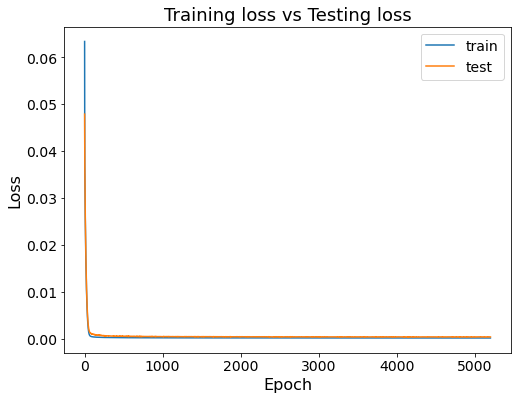

In [31]:
lr = 0.0001
EPOCHS = 6000

# initial_learning_rate * decay_rate ^ (step / decay_steps)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)

model_rnn.compile(
    optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer=Adam(learning_rate=lr_schedule), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/rnn_shift_anyday_24h_4layer_sc.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_rnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [32]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/rnn_shift_anyday_24h_4layer_sc.h5')

In [33]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
(19268, 96)


In [34]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.07
RMSE = 0.096
